# Process of moving from popular time series prediction to increasingly capable predictions

In [1]:
# Requirements
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# pip install -U yfinance scikit-learn pandas numpy accelerate flash-attention tensorflow keras matplotlib giotto-tda

## Example stock forecast from YouTube video
https://www.youtube.com/watch?v=5xvAtypnLC0&t=816s

[*********************100%***********************]  1 of 1 completed
2024-09-28 15:25:03.320409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 15:25:03.350662: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-28 15:25:03.361738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-28 15:25:03.400025: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate 

Epoch 1/10


I0000 00:00:1727555112.391066   13343 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727555112.391491   13343 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-28 15:25:12.671860: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/silwa/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Inpu

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0258
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2.3082e-04
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.0191e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.9910e-04
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.1362e-04
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.8699e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.9223e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.8379e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.9239e-04
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.9004e-04
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4841e-04
Test Loss: 0.00026633363449946046
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


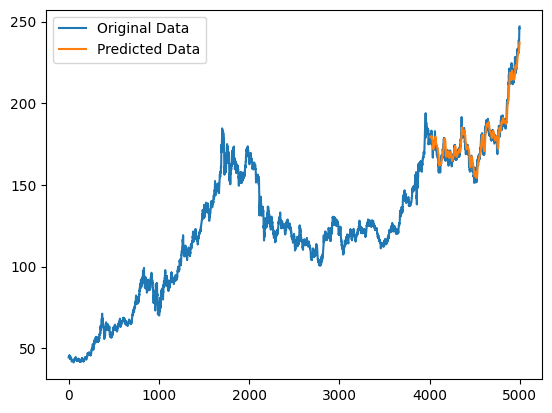

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


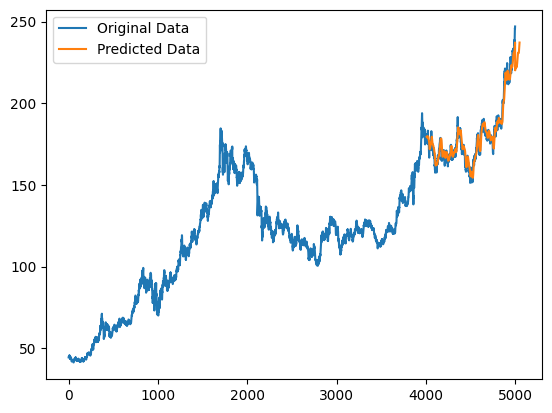

In [2]:
import yfinance as yf

stock_data_orig = yf.download('GLD', start='2000-01-01', end='2024-09-27')
stock_data = stock_data_orig

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))

import numpy as np

def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)
	
time_step = 50
X, y = create_dataset(scaled_data, time_step)

train_size=0.8
X_train, X_test = X[:int(X.shape[0]*train_size)], X[int(X.shape[0]*train_size):]
y_train, y_test = y[:int(y.shape[0]*train_size)], y[int(y.shape[0]*train_size):]

from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=64))
model.add(Dense(units=64))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=64)

test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(predictions):] = predictions.reshape(-1)

import matplotlib.pyplot as plt

plt.plot(original_data, label='Original Data')
plt.plot(predicted_data, label='Predicted Data')
plt.legend()
plt.show()

new_predictions = model.predict(X_test[-50:])
new_predictions = scaler.inverse_transform(new_predictions)

predicted_data = np.append(predicted_data, new_predictions)
predicted_data[-20:]

plt.plot(original_data, label='Original Data')
plt.plot(predicted_data, label='Predicted Data')
plt.legend()
plt.show()

## Refactor to use torch instead of tensorflow

In [3]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

Epoch [1/10], Loss: 0.0040
Epoch [2/10], Loss: 0.0002
Epoch [3/10], Loss: 0.0002
Epoch [4/10], Loss: 0.0004
Epoch [5/10], Loss: 0.0002
Epoch [6/10], Loss: 0.0001
Epoch [7/10], Loss: 0.0001
Epoch [8/10], Loss: 0.0002
Epoch [9/10], Loss: 0.0002
Epoch [10/10], Loss: 0.0001
Test Loss: 0.00034302822314202785


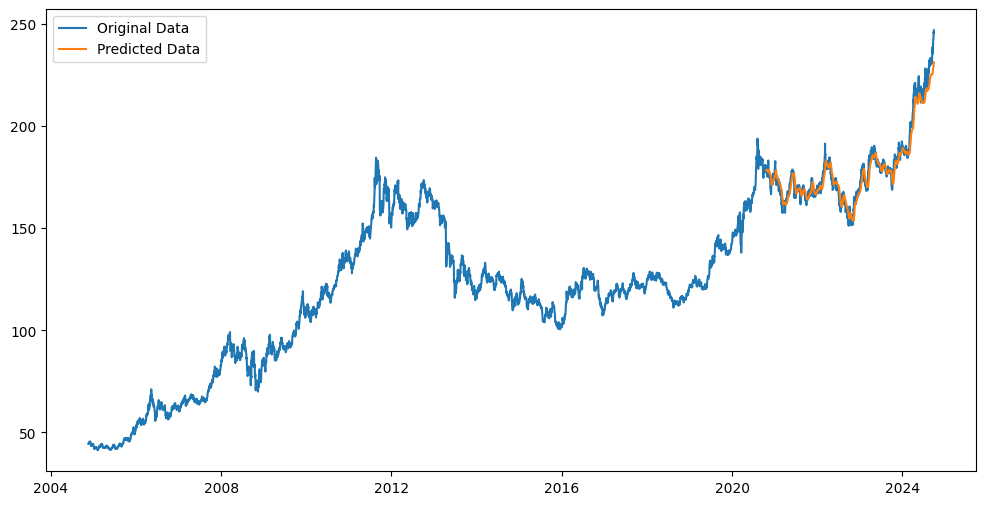

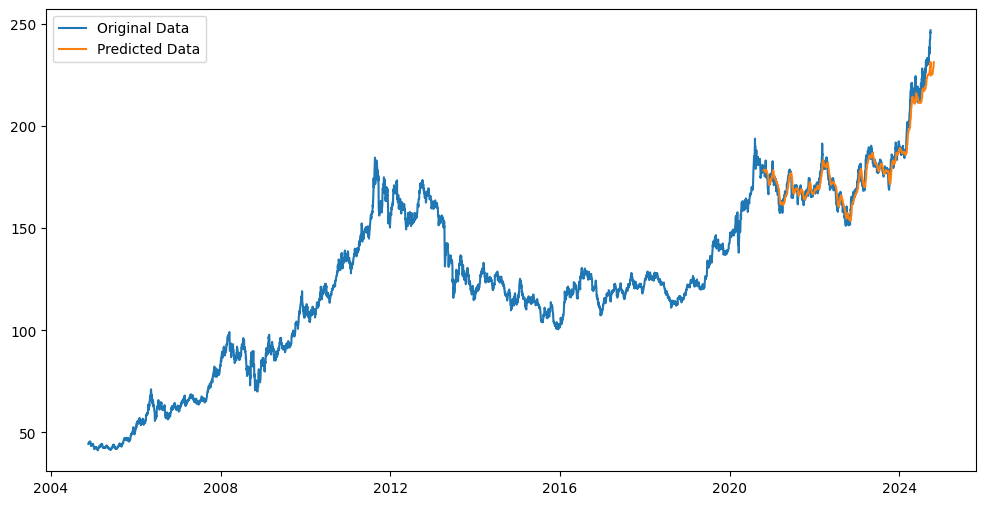

In [4]:
# Download stock data
stock_data = stock_data_orig

# Scale the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))

# Function to create dataset
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Create the dataset
time_step = 50
X, y = create_dataset(scaled_data, time_step)

# Split into training and testing sets
train_size = 0.8
train_size_int = int(X.shape[0]*train_size)
X_train, X_test = X[:train_size_int], X[train_size_int:]
y_train, y_test = y[:train_size_int], y[train_size_int:]

# Convert to torch tensors and reshape
X_train = torch.from_numpy(X_train).float().unsqueeze(2)
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float().unsqueeze(2)
y_test = torch.from_numpy(y_test).float()

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size

        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]  # Get the last output
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Instantiate the model
model = LSTMModel()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate test loss
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs.squeeze(), y_test)
    print('Test Loss:', test_loss.item())

# Make predictions on X_test
with torch.no_grad():
    test_predictions = model(X_test)
    test_predictions = test_predictions.detach().numpy()
    test_predictions_scaled = scaler.inverse_transform(test_predictions)

# Prepare data for plotting
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(test_predictions_scaled):] = test_predictions_scaled.reshape(-1)

# Plot original data and predicted data
plt.figure(figsize=(12,6))
plt.plot(stock_data.index, original_data, label='Original Data')
plt.plot(stock_data.index, predicted_data, label='Predicted Data')
plt.legend()
plt.show()

# Forecast the next 90 days using last 90 sequences from X_test
with torch.no_grad():
    future_inputs = X_test[-20:]
    future_predictions = model(future_inputs)
    future_predictions = future_predictions.detach().numpy()
    future_predictions_scaled = scaler.inverse_transform(future_predictions)

# Prepare data for plotting
# Extend dates for future predictions
future_dates = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=20, freq='B')
full_dates = stock_data.index.append(future_dates)

# Append future predictions to predicted_data
predicted_data_full = np.concatenate((predicted_data, future_predictions_scaled.reshape(-1)))
original_data_full = np.concatenate((original_data, [np.nan]*20))

# Plot the data including future predictions
plt.figure(figsize=(12,6))
plt.plot(full_dates, original_data_full, label='Original Data')
plt.plot(full_dates, predicted_data_full, label='Predicted Data')
plt.legend()
plt.show()

## Refactor to use NASA-IBM climate model for wave propagation based on https://github.com/NASA-IMPACT/gravity-wave-finetuning/blob/main/gravity_wave_model.py

Using device: cuda


/home/silwa/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 0.0009
Epoch [2/10], Loss: 0.0007
Epoch [3/10], Loss: 0.0003
Epoch [4/10], Loss: 0.0004
Epoch [5/10], Loss: 0.0006
Epoch [6/10], Loss: 0.0003
Epoch [7/10], Loss: 0.0008
Epoch [8/10], Loss: 0.0001
Epoch [9/10], Loss: 0.0009
Epoch [10/10], Loss: 0.0002
Test Loss: 0.0061154114082455635


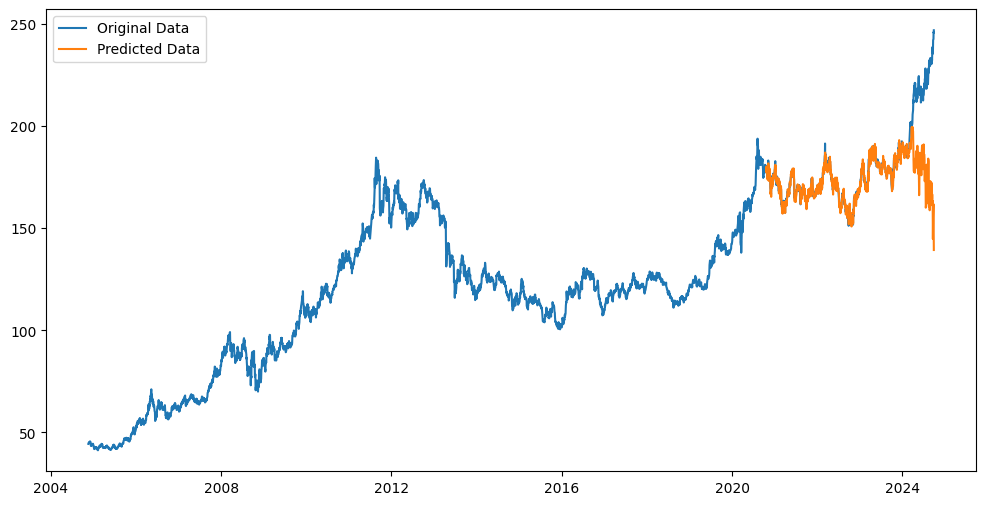

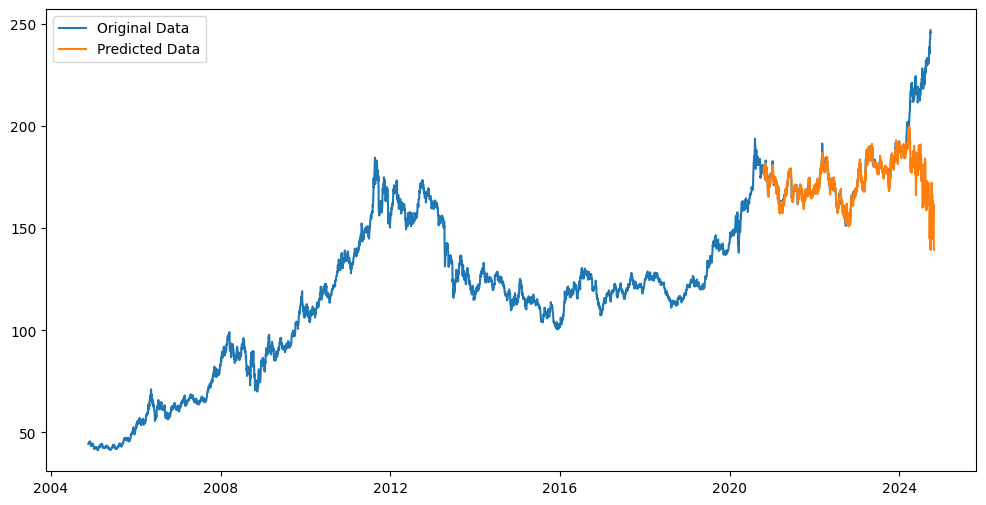

In [5]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

days_back = 50
days_ahead = 20

# Download stock data
stock_data = stock_data_orig

# Scale the 'Close' prices
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))

# Function to create dataset
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Create the dataset
time_step = days_back
X, y = create_dataset(scaled_data, time_step)

# Split into training and testing sets
train_size = 0.8
train_size_int = int(X.shape[0]*train_size)
X_train, X_test = X[:train_size_int], X[train_size_int:]
y_train, y_test = y[:train_size_int], y[train_size_int:]

# Convert to torch tensors and reshape
X_train = torch.from_numpy(X_train).float().unsqueeze(1).to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().unsqueeze(1).to(device)
y_test = torch.from_numpy(y_test).float().to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(Encoder, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder2 = nn.Sequential(
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder3 = nn.Sequential(
            nn.Conv1d(hidden_channels * 2, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 4, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc1_pooled = self.pool1(enc1)
        enc2 = self.encoder2(enc1_pooled)
        enc2_pooled = self.pool2(enc2)
        enc3 = self.encoder3(enc2_pooled)
        enc3_pooled = self.pool3(enc3)
        return enc1, enc2, enc3, enc3_pooled

class Decoder(nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super(Decoder, self).__init__()

        self.up3 = nn.ConvTranspose1d(
            hidden_channels * 4,  # in_channels (256)
            hidden_channels * 4,  # out_channels (256)
            kernel_size=2,
            stride=2,
            # Remove output_padding to let the layer compute the necessary size
        )

        self.decoder3 = nn.Sequential(
            nn.Conv1d(hidden_channels * 8, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 4, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
        )

        self.up2 = nn.ConvTranspose1d(
            hidden_channels * 4,  # in_channels (256)
            hidden_channels * 2,  # out_channels (128)
            kernel_size=2,
            stride=2
        )

        self.decoder2 = nn.Sequential(
            nn.Conv1d(hidden_channels * 4, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
        )

        self.up1 = nn.ConvTranspose1d(
            hidden_channels * 2,  # in_channels (128)
            hidden_channels,      # out_channels (64)
            kernel_size=2,
            stride=2
        )

        self.decoder1 = nn.Sequential(
            nn.Conv1d(hidden_channels * 2, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
        )

        self.final_conv = nn.Conv1d(hidden_channels, out_channels, kernel_size=1)

    def forward(self, enc1, enc2, enc3, bottleneck):
        up3 = self.up3(bottleneck)  # Upsample

        # Adjust sequence lengths to match for concatenation
        diff3 = up3.size(2) - enc3.size(2)
        if diff3 > 0:
            up3 = up3[:, :, :-diff3]
        elif diff3 < 0:
            enc3 = enc3[:, :, :-(-diff3)]
        dec3 = torch.cat((up3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        up2 = self.up2(dec3)
        diff2 = up2.size(2) - enc2.size(2)
        if diff2 > 0:
            up2 = up2[:, :, :-diff2]
        elif diff2 < 0:
            enc2 = enc2[:, :, :-(-diff2)]
        dec2 = torch.cat((up2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        up1 = self.up1(dec2)
        diff1 = up1.size(2) - enc1.size(2)
        if diff1 > 0:
            up1 = up1[:, :, :-diff1]
        elif diff1 < 0:
            enc1 = enc1[:, :, :-(-diff1)]
        dec1 = torch.cat((up1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        output = self.final_conv(dec1)
        return output



# Define the Transformer Bottleneck
class TransformerBottleneck(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, dim_feedforward):
        super(TransformerBottleneck, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        # x shape: (batch_size, channels, seq_len)
        # Need to permute to (seq_len, batch_size, channels)
        x = x.permute(2, 0, 1)
        x = self.transformer(x)
        # Permute back to (batch_size, channels, seq_len)
        x = x.permute(1, 2, 0)
        return x

# Define the complete model
class UNetWithTransformer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(UNetWithTransformer, self).__init__()
        self.encoder = Encoder(in_channels, hidden_channels)
        self.transformer = TransformerBottleneck(input_dim=hidden_channels * 4, nhead=8, num_layers=4, dim_feedforward=512)
        self.decoder = Decoder(hidden_channels, out_channels)

    def forward(self, x):
        enc1, enc2, enc3, bottleneck = self.encoder(x)
        bottleneck = self.transformer(bottleneck)
        output = self.decoder(enc1, enc2, enc3, bottleneck)
        # Assuming output is of shape (batch_size, out_channels, seq_len)
        # For regression, we can take the last time step
        output = output[:, :, -1]
        return output.squeeze()

# Instantiate the model
model = UNetWithTransformer(in_channels=1, hidden_channels=16, out_channels=1).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate test loss
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print('Test Loss:', test_loss.item())

# Make predictions on X_test
with torch.no_grad():
    test_predictions = model(X_test)
    test_predictions = test_predictions.cpu().detach().numpy()
    test_predictions_scaled = scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Prepare data for plotting
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(test_predictions_scaled):] = test_predictions_scaled.reshape(-1)

# Plot original data and predicted data
plt.figure(figsize=(12,6))
plt.plot(stock_data.index, original_data, label='Original Data')
plt.plot(stock_data.index, predicted_data, label='Predicted Data')
plt.legend()
plt.show()

# Forecast the next days ahead using last days ahead sequences from X_test
with torch.no_grad():
    future_inputs = X_test[-days_ahead:]
    future_predictions = model(future_inputs)
    future_predictions = future_predictions.cpu().detach().numpy()
    future_predictions_scaled = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Prepare data for plotting
# Extend dates for future predictions
future_dates = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=days_ahead, freq='B')
full_dates = stock_data.index.append(future_dates)

# Append future predictions to predicted_data
predicted_data_full = np.concatenate((predicted_data, future_predictions_scaled.reshape(-1)))
original_data_full = np.concatenate((original_data, [np.nan]*days_ahead))

# Plot the data including future predictions
plt.figure(figsize=(12,6))
plt.plot(full_dates, original_data_full, label='Original Data')
plt.plot(full_dates, predicted_data_full, label='Predicted Data')
plt.legend()
plt.show()

## Add feature engineering

In [6]:
def get_rsi_timeseries(prices, n=1):
    deltas = (prices - prices.shift(1)).fillna(0)

    avg_of_gains = deltas[1:n+1][deltas > 0].sum() / n
    avg_of_losses = -deltas[1:n+1][deltas < 0].sum() / n

    # Set up pd.Series container for RSI values
    rsi_series = pd.Series(0.0, deltas.index)

    # Now calculate RSI using the Wilder smoothing method, starting with n+1 delta.
    up = lambda x: x if x > 0 else 0
    down = lambda x: -x if x < 0 else 0
    i = n+1
    for d in deltas[n+1:]:
        avg_of_gains = ((avg_of_gains * (n-1)) + up(d)) / n
        avg_of_losses = ((avg_of_losses * (n-1)) + down(d)) / n
        if avg_of_losses != 0:
            rs = avg_of_gains / avg_of_losses
            rsi_series.iloc[i] = 100 - (100 / (1 + rs))  # Fix is here
        else:
            rsi_series.iloc[i] = 100  # Fix is here
        i += 1

    return rsi_series
    
def tr(data):
    data['previous_close'] = data['Close'].shift(1)
    data['high-low'] = abs(data['High'] - data['Low'])
    data['high-pc'] = abs(data['High'] - data['previous_close'])
    data['low-pc'] = abs(data['Low'] - data['previous_close'])
    tr = data[['high-low', 'high-pc', 'low-pc']].max(axis=1)
    return tr

def atr(data, period):
    data['tr'] = tr(data)
    atr = data['tr'].rolling(period).mean()
    return atr
    
def supertrend(df, period=7, atr_multiplier=2.5):
    hl2 = (df['High'] + df['Low']) / 2
    df['atr'] = atr(df, period)
    df['upperband'] = hl2 + (atr_multiplier * df['atr'])
    df['lowerband'] = hl2 - (atr_multiplier * df['atr'])
    df['in_uptrend'] = 1

    for current in range(1, len(df.index)):
        previous = current - 1

        if df['Close'].iloc[current] > df['upperband'].iloc[previous]:
            df.loc[df.index[current], 'in_uptrend'] = 1
        elif df['Close'].iloc[current] < df['lowerband'].iloc[previous]:
            df.loc[df.index[current], 'in_uptrend'] = 0
        else:
            df.loc[df.index[current], 'in_uptrend'] = df.loc[df.index[previous], 'in_uptrend']

            if df['in_uptrend'].iloc[current] and df['lowerband'].iloc[current] < df['lowerband'].iloc[previous]:
                df.loc[df.index[current], 'lowerband'] = df.loc[df.index[previous], 'lowerband']

            if not df['in_uptrend'].iloc[current] and df['upperband'].iloc[current] > df['upperband'].iloc[previous]:
                df.loc[df.index[current], 'upperband'] = df.loc[df.index[previous], 'upperband']
        
    return df
    
def calculate_technical_indicators(df):
    # Bollinger Bands
    df['20_day_SMA'] = df['Adj Close'].rolling(window=20).mean()
    df['20_day_STD'] = df['Adj Close'].rolling(window=20).std()
    df['Upper_Band'] = df['20_day_SMA'] + (df['20_day_STD'] * 2)
    df['Lower_Band'] = df['20_day_SMA'] - (df['20_day_STD'] * 2)
    df['Bollinger_Band_Width'] = df['Upper_Band'] - df['Lower_Band']
    
    # MACD
    df['26_ema'] = df['Adj Close'].ewm(span=26).mean()
    df['12_ema'] = df['Adj Close'].ewm(span=12).mean()
    df['MACD'] = df['12_ema'] - df['26_ema']
    df['Signal_Line'] = df['MACD'].ewm(span=9).mean()
    
    # Stochastic Oscillator
    df['14_High'] = df['High'].rolling(14).max()
    df['14_Low'] = df['Low'].rolling(14).min()
    df['%K'] = 100*((df['Close'] - df['14_Low']) / (df['14_High'] - df['14_Low']) )
    df['%D'] = df['%K'].rolling(window=3).mean()
    
    # Williams %R
    df['Williams_%R'] = -100 * (df['14_High'] - df['Close']) / (df['14_High'] - df['14_Low'])
    
    # Accumulation/Distribution Line
    df['CLV'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    df['CLV'] = df['CLV'].fillna(0)  # NaN and inf values will be replaced with 0
    df['ADL'] = (df['CLV'] * df['Volume']).cumsum()
    
    # On Balance Volume
    df['OBV'] = (np.sign(df['Close'].diff()).fillna(0) * df['Volume']).cumsum()
    
    # Historical Volatility
    df['Log_ret'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df['Historical_Volatility'] = df['Log_ret'].rolling(window=252).std() * np.sqrt(252)
    
    # VWAP
    df['Cumulative_Volume_Price'] = (df['Volume'] * df['Adj Close']).cumsum()
    df['Cumulative_Volume'] = df['Volume'].cumsum()
    df['VWAP'] = df['Cumulative_Volume_Price'] / df['Cumulative_Volume']
    df['smaVWAP'] = df['VWAP'].rolling(window=10,min_periods=1).mean()
   
    return df

# Calculate the features
def calculate_features(df):
    df['hlc3'] = (df['Close'] + df['High'] + df['Low']) / 3.0
    df['sma3'] = df['hlc3'].rolling(window=3,min_periods=1).mean()
    df['ema1'] = df['hlc3'].ewm(span=7).mean()
    df['ema2'] = df['hlc3'].ewm(span=16).mean()
    df['ema3'] =  df['hlc3'].ewm(span=25).mean()
    df['MACD'] = (df['ema1'] - df['ema3'])
    df['rsi'] = get_rsi_timeseries(df['Adj Close'], 12)
    df['SMArsi'] = df['rsi'].rolling(window=15,min_periods=1).mean()
    df['drsi'] = df['rsi'] - df['SMArsi']
    df['dSMArsi'] = df['SMArsi'].shift(1).fillna(0).astype(float) - df['SMArsi']
    df['smah4'] = df['High'].rolling(window=4,min_periods=1).mean()
    df['smal4'] = df['Low'].rolling(window=4,min_periods=1).mean()
    df['dsmah4'] = df['Adj Close'] - df['smah4']
    
    # Create Bollinger Bands
    df['sma10'] = df['Adj Close'].rolling(window=10,min_periods=1).mean()
    
    # tech indicators
    df = calculate_technical_indicators(df)
    
    df = supertrend(df)
    df['kst'] = df['sma3'] - df['ema1'] + df['sma3'] - df['ema2'] + df['sma3'] - df['ema3']
    df['SMAkst'] = df['kst'].rolling(window=15,min_periods=1).mean()
    df['dkst'] = df['SMAkst'] - df['kst']
    df['wema1'] = df['hlc3'] - df['ema1']
    df['wema2'] = df['hlc3'] - df['ema2']
    df['wema3'] = df['hlc3'] - df['ema3']
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.fillna(0)
    
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index

    return df

In [7]:
# Download stock data
stock_data = stock_data_orig

stock_data = calculate_features(stock_data)

# List of features (including 'Close')
FEATURE_COLUMNS = ["Adj Close", "hlc3", "ema1", "ema2", "ema3", "rsi", "SMArsi"]

# Drop any rows with NaN values (optional depending on your data)
stock_data.dropna(inplace=True)

days_ahead = 20
days_back = 50  # Adjust as needed

In [8]:
stock_data

,Open,High,Low,Close,Adj Close,Volume,hlc3,sma3,ema1,ema2,...,upperband,lowerband,in_uptrend,kst,SMAkst,dkst,wema1,wema2,wema3,date
Date,,,,,,,,,,,,,,,,,,,,,
2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000,44.313334,44.313334,44.313334,44.313334,...,0.000000,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2004-11-18
2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300,44.723333,44.518333,44.547619,44.531146,...,0.000000,0.000000,1,-0.050298,-0.025149,0.025149,0.175714,0.192187,0.196799,2004-11-19
2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000,44.886668,44.641112,44.694235,44.664756,...,0.000000,0.000000,1,-0.091960,-0.047419,0.044541,0.192433,0.221912,0.230363,2004-11-22
2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200,44.796666,44.802222,44.731695,44.704157,...,0.000000,0.000000,1,0.275101,0.033211,-0.241890,0.064971,0.092509,0.100953,2004-11-23
2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100,44.963333,44.882222,44.807623,44.769705,...,0.000000,0.000000,1,0.311210,0.088811,-0.222400,0.155710,0.193628,0.205204,2004-11-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-20,241.110001,242.630005,240.470001,242.210007,242.210007,7737400,241.770004,239.165556,238.011737,235.345678,...,249.617859,233.482147,1,10.726203,6.667934,-4.058269,3.758267,6.424327,8.356954,2024-09-20
2024-09-23,242.970001,243.460007,242.589996,242.679993,242.679993,5426200,242.909999,241.124446,239.236303,236.235598,...,250.039287,236.010716,1,13.757851,7.191699,-6.566152,3.673696,6.674401,8.766414,2024-09-23
2024-09-24,243.389999,246.190002,243.149994,246.070007,246.070007,8386300,245.136668,243.272224,240.711394,237.282782,...,251.991432,237.348564,1,16.833288,8.008980,-8.824308,4.425274,7.853885,10.147461,2024-09-24


In [9]:
# Scale each feature individually
scalers = {}
for feature in FEATURE_COLUMNS:
    scalers[feature] = MinMaxScaler(feature_range=(0.05, 0.95))
    stock_data[feature] = scalers[feature].fit_transform(stock_data[feature].values.reshape(-1, 1))

# Create the dataset with multiple features
def create_multifeature_dataset(data, features, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[features].values[i:(i + time_step)])  # Multi-feature input
        y.append(data['Adj Close'].values[i + time_step])       # Predicting close price
    return np.array(X), np.array(y)

# Create the dataset
time_step = days_back
X, y = create_multifeature_dataset(stock_data, FEATURE_COLUMNS, time_step)

# Split into training and testing sets
train_size = 0.8
train_size_int = int(X.shape[0] * train_size)
X_train, X_test = X[:train_size_int], X[train_size_int:]
y_train, y_test = y[:train_size_int], y[train_size_int:]

# Convert to torch tensors and reshape
X_train = torch.from_numpy(X_train).float().to(device)  # No need to unsqueeze as we have multi-feature input
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Update Encoder and Decoder to handle multiple features
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(Encoder, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder2 = nn.Sequential(
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder3 = nn.Sequential(
            nn.Conv1d(hidden_channels * 2, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 4, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc1_pooled = self.pool1(enc1)
        enc2 = self.encoder2(enc1_pooled)
        enc2_pooled = self.pool2(enc2)
        enc3 = self.encoder3(enc2_pooled)
        enc3_pooled = self.pool3(enc3)
        return enc1, enc2, enc3, enc3_pooled

# (The Decoder and Transformer bottleneck remain the same)

# Define the complete model
class UNetWithTransformer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(UNetWithTransformer, self).__init__()
        self.encoder = Encoder(in_channels, hidden_channels)
        self.transformer = TransformerBottleneck(input_dim=hidden_channels * 4, nhead=8, num_layers=4, dim_feedforward=512)
        self.decoder = Decoder(hidden_channels, out_channels)

    def forward(self, x):
        # Permute x to (batch_size, num_features, time_steps) for Conv1d
        x = x.permute(0, 2, 1)
        
        # Pass through the encoder, transformer, and decoder
        enc1, enc2, enc3, bottleneck = self.encoder(x)
        bottleneck = self.transformer(bottleneck)
        output = self.decoder(enc1, enc2, enc3, bottleneck)
        # For regression, take the last time step
        output = output[:, :, -1]
        return output.squeeze()

# Instantiate the model
model = UNetWithTransformer(in_channels=len(FEATURE_COLUMNS), hidden_channels=16, out_channels=1).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (same as before)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

/home/silwa/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 0.0038
Epoch [2/10], Loss: 0.0017
Epoch [3/10], Loss: 0.0005
Epoch [4/10], Loss: 0.0014
Epoch [5/10], Loss: 0.0004
Epoch [6/10], Loss: 0.0003
Epoch [7/10], Loss: 0.0002
Epoch [8/10], Loss: 0.0002
Epoch [9/10], Loss: 0.0002
Epoch [10/10], Loss: 0.0003


Test Loss: 0.00041945301927626133


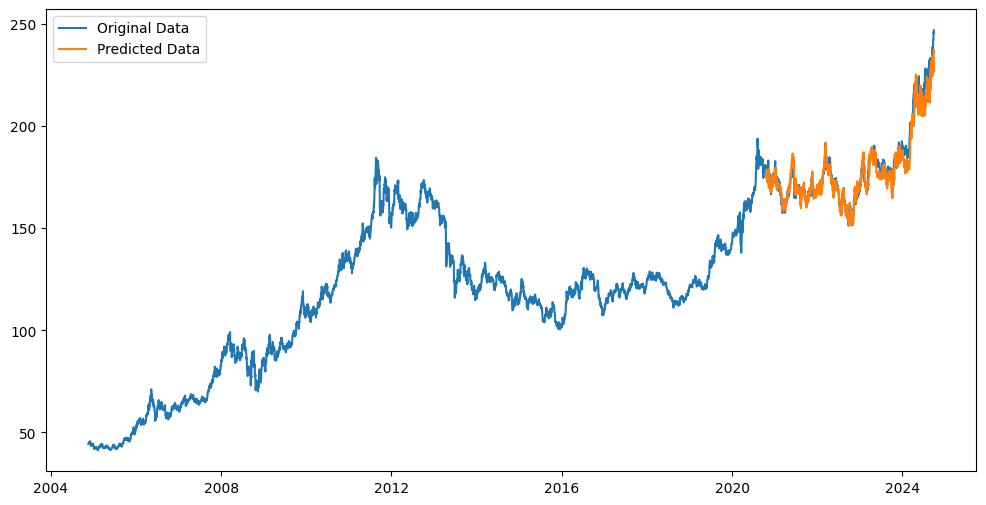

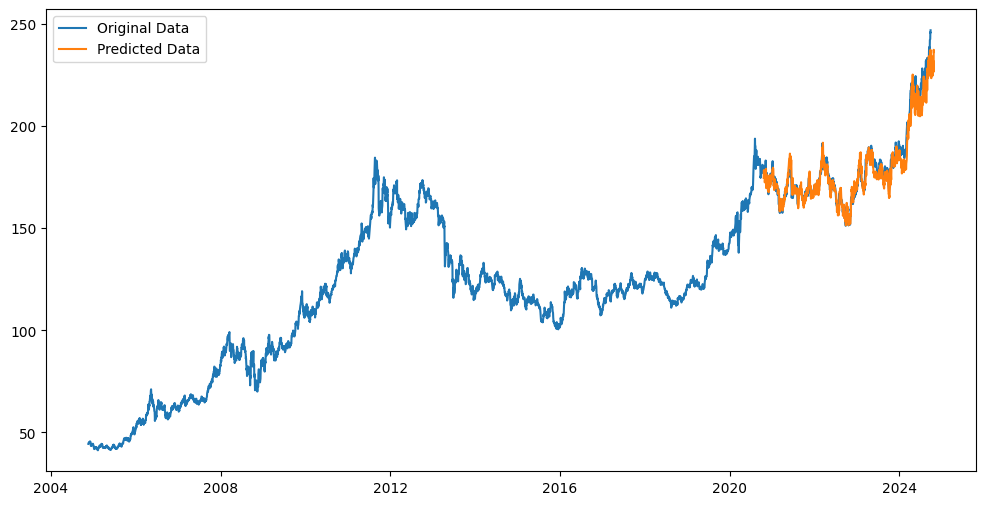

In [10]:
# Evaluate test loss
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print('Test Loss:', test_loss.item())

# Make predictions on X_test
with torch.no_grad():
    test_predictions = model(X_test)
    test_predictions = test_predictions.cpu().detach().numpy()
    test_predictions_scaled = scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Prepare data for plotting
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(test_predictions_scaled):] = test_predictions_scaled.reshape(-1)

# Plot original data and predicted data
plt.figure(figsize=(12,6))
plt.plot(stock_data.index, original_data, label='Original Data')
plt.plot(stock_data.index, predicted_data, label='Predicted Data')
plt.legend()
plt.show()

# Forecast the next days ahead using last days ahead sequences from X_test
with torch.no_grad():
    future_inputs = X_test[-days_ahead:]
    future_predictions = model(future_inputs)
    future_predictions = future_predictions.cpu().detach().numpy()
    future_predictions_scaled = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Prepare data for plotting
# Extend dates for future predictions
future_dates = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=days_ahead, freq='B')
full_dates = stock_data.index.append(future_dates)

# Append future predictions to predicted_data
predicted_data_full = np.concatenate((predicted_data, future_predictions_scaled.reshape(-1)))
original_data_full = np.concatenate((original_data, [np.nan]*days_ahead))

# Plot the data including future predictions
plt.figure(figsize=(12,6))
plt.plot(full_dates, original_data_full, label='Original Data')
plt.plot(full_dates, predicted_data_full, label='Predicted Data')
plt.legend()
plt.show()

## Now lets add a persistant homology feature from topological data analysis

In [11]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from gtda.time_series import TakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [12]:
# Download stock data
stock_data = stock_data_orig

stock_data = calculate_features(stock_data)  # Assuming you have a function to calculate other features

# List of features (including 'Adj Close')
FEATURE_COLUMNS = ["Adj Close", "hlc3", "ema1", "ema2", "ema3", "rsi", "SMArsi"]

# Drop any rows with NaN values (optional depending on your data)
stock_data.dropna(inplace=True)

# Define your time_step (days_back) if not defined
days_back = 50  # Adjust as needed
# Define the number of days ahead you want to predict
days_ahead = 20  # Adjust as needed

In [13]:
# ------------------------ #
# Part 1: TDA Feature Engineering
# ------------------------ #

# Prepare the time series windows for TDA feature extraction
adj_close = stock_data['Adj Close'].values

# Parameters for windowing
window_size = 100  # Adjust as needed
window_stride = 1  # Adjust as needed

def create_time_series_windows(data, window_size, stride):
    windows = []
    indices = []
    for i in range(0, len(data) - window_size + 1, stride):
        windows.append(data[i:i+window_size])
        indices.append(i)
    return np.array(windows), indices

time_series_windows, window_indices = create_time_series_windows(adj_close, window_size, window_stride)

# Set up the TDA pipeline
embedding_dimension = 30  # Adjust as needed
embedding_time_delay = 1  # Adjust as needed

embedder = TakensEmbedding(time_delay=embedding_time_delay,
                           dimension=embedding_dimension,
                           stride=1)  # Since our windows are already sampled

batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)

persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)

scaling = Scaler()

entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)

steps = [("embedder", embedder),
         ("pca", batch_pca),
         ("persistence", persistence),
         ("scaling", scaling),
         ("entropy", entropy)]

topological_transformer = Pipeline(steps)

# Apply the pipeline to time_series_windows
features = topological_transformer.fit_transform(time_series_windows)

# Create DataFrame with features and timestamps
timestamps = stock_data.index.values

# Align features with corresponding timestamps
feature_timestamps = [timestamps[i + window_size - 1] for i in window_indices]

features_df = pd.DataFrame(features, index=feature_timestamps, columns=['entropy_H0', 'entropy_H1'])

# Merge features_df into stock_data
stock_data = stock_data.merge(features_df, how='left', left_index=True, right_index=True)

# Drop NaN values resulting from the merging
stock_data.dropna(inplace=True)

# Update FEATURE_COLUMNS to include the new features
FEATURE_COLUMNS.extend(['entropy_H0', 'entropy_H1'])

In [14]:
# ------------------------ #
# Part 2: Scaling Features
# ------------------------ #

# Scale each feature individually
scalers = {}
for feature in FEATURE_COLUMNS:
    scalers[feature] = MinMaxScaler(feature_range=(0.05, 0.95))
    stock_data[feature] = scalers[feature].fit_transform(stock_data[feature].values.reshape(-1, 1))

# ------------------------ #
# Part 3: Prepare Dataset and Model Training
# ------------------------ #

# Create the dataset with multiple features
def create_multifeature_dataset(data, features, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[features].values[i:(i + time_step)])  # Multi-feature input
        y.append(data['Adj Close'].values[i + time_step])       # Predicting close price
    return np.array(X), np.array(y)


time_step = days_back
X, y = create_multifeature_dataset(stock_data, FEATURE_COLUMNS, time_step)

# Split into training and testing sets
train_size = 0.8
train_size_int = int(X.shape[0] * train_size)
X_train, X_test = X[:train_size_int], X[train_size_int:]
y_train, y_test = y[:train_size_int], y[train_size_int:]

# Convert to torch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [15]:
# ------------------------ #
# Part 4: Define Model (Assuming Encoder, Decoder, Transformer are defined)
# ------------------------ #
# Update Encoder and Decoder to handle multiple features
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(Encoder, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder2 = nn.Sequential(
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder3 = nn.Sequential(
            nn.Conv1d(hidden_channels * 2, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 4, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc1_pooled = self.pool1(enc1)
        enc2 = self.encoder2(enc1_pooled)
        enc2_pooled = self.pool2(enc2)
        enc3 = self.encoder3(enc2_pooled)
        enc3_pooled = self.pool3(enc3)
        return enc1, enc2, enc3, enc3_pooled

# (The Decoder and Transformer bottleneck remain the same)

# Define the complete model
class UNetWithTransformer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(UNetWithTransformer, self).__init__()
        self.encoder = Encoder(in_channels, hidden_channels)
        self.transformer = TransformerBottleneck(input_dim=hidden_channels * 4, nhead=8, num_layers=4, dim_feedforward=512)
        self.decoder = Decoder(hidden_channels, out_channels)

    def forward(self, x):
        # Permute x to (batch_size, num_features, time_steps) for Conv1d
        x = x.permute(0, 2, 1)
        
        # Pass through the encoder, transformer, and decoder
        enc1, enc2, enc3, bottleneck = self.encoder(x)
        bottleneck = self.transformer(bottleneck)
        output = self.decoder(enc1, enc2, enc3, bottleneck)
        # For regression, take the last time step
        output = output[:, :, -1]
        return output.squeeze()


In [16]:
# Instantiate the model
model = UNetWithTransformer(in_channels=len(FEATURE_COLUMNS), hidden_channels=16, out_channels=1).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ------------------------ #
# Part 5: Training Loop
# ------------------------ #

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

/home/silwa/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 0.0011
Epoch [2/10], Loss: 0.0011
Epoch [3/10], Loss: 0.0013
Epoch [4/10], Loss: 0.0030
Epoch [5/10], Loss: 0.0016
Epoch [6/10], Loss: 0.0005
Epoch [7/10], Loss: 0.0005
Epoch [8/10], Loss: 0.0006
Epoch [9/10], Loss: 0.0014
Epoch [10/10], Loss: 0.0004


Test Loss: 0.0002850921009667218


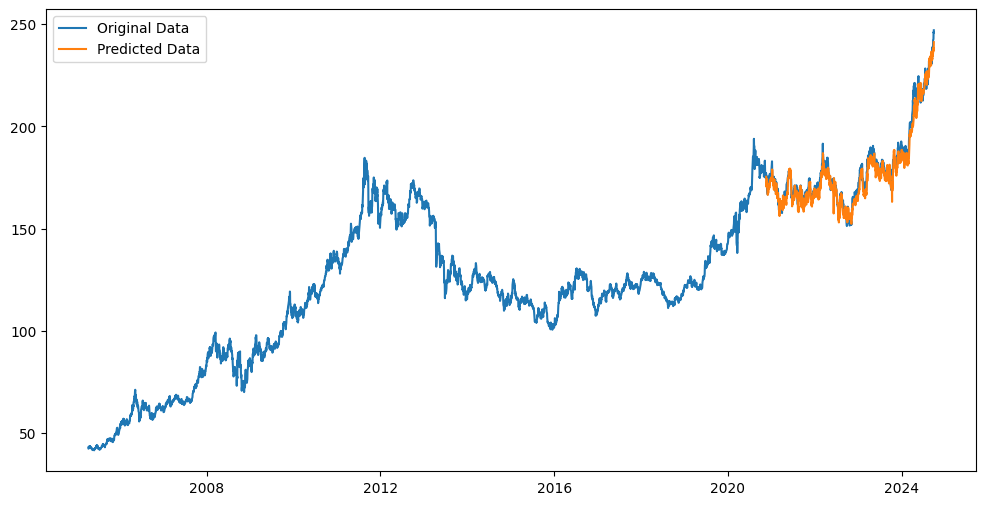

In [17]:
# ------------------------ #
# Part 6: Evaluation and Forecasting
# ------------------------ #

# Evaluate test loss
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print('Test Loss:', test_loss.item())

# Make predictions on X_test
with torch.no_grad():
    test_predictions = model(X_test)
    test_predictions = test_predictions.cpu().detach().numpy()
    test_predictions_scaled = scalers['Adj Close'].inverse_transform(test_predictions.reshape(-1, 1))

# Prepare data for plotting
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(test_predictions_scaled):] = test_predictions_scaled.reshape(-1)

# Plot original data and predicted data
plt.figure(figsize=(12,6))
plt.plot(stock_data.index, original_data, label='Original Data')
plt.plot(stock_data.index, predicted_data, label='Predicted Data')
plt.legend()
plt.show()

In [18]:


# Initialize a list to store future predictions
future_predictions_scaled = []

# Start with the last available input sequence from your data
last_sequence = X_test[-1].cpu().numpy()  # Shape: (time_step, num_features)

# Loop to predict each future day iteratively
for _ in range(days_ahead):
    # Convert last_sequence to tensor and move to device
    input_seq = torch.from_numpy(last_sequence).unsqueeze(0).float().to(device)  # Shape: (1, time_step, num_features)
    
    # Make prediction
    with torch.no_grad():
        pred = model(input_seq)
    
    # Ensure pred is a tensor of shape (1,)
    if pred.dim() == 0:
        pred = pred.unsqueeze(0)
    
    # Convert prediction to NumPy array
    pred_np = pred.cpu().numpy()  # Shape: (1,)
    
    # Inverse transform the prediction
    pred_scaled = scalers['Adj Close'].inverse_transform(pred_np.reshape(-1, 1))[0][0]
    
    # Append prediction to the list
    future_predictions_scaled.append(pred_scaled)
    
    # Prepare the new features for the next time step
    new_features = np.zeros((1, len(FEATURE_COLUMNS)))
    
    # Update 'Adj Close' with the predicted normalized value
    pred_scaled_norm = scalers['Adj Close'].transform(pred_np.reshape(-1, 1))[0][0]
    new_features[0][FEATURE_COLUMNS.index('Adj Close')] = pred_scaled_norm
    
    # For other features, either keep them constant or update if possible
    for idx, feature in enumerate(FEATURE_COLUMNS):
        if feature == 'Adj Close':
            continue
        elif feature in ['hlc3', 'ema1', 'ema2', 'ema3', 'rsi', 'VWAP', 'smaVWAP', 'SMAkst']:
            # You can attempt to update these features if you have formulas
            # For now, we'll keep them the same as the last known values
            new_features[0][idx] = last_sequence[-1][idx]
        elif feature in ['entropy_H0', 'entropy_H1']:
            # Keep TDA features constant
            new_features[0][idx] = last_sequence[-1][idx]
        else:
            # For any other features, keep the last known value
            new_features[0][idx] = last_sequence[-1][idx]
    
    # Update last_sequence
    last_sequence = np.vstack((last_sequence[1:], new_features))


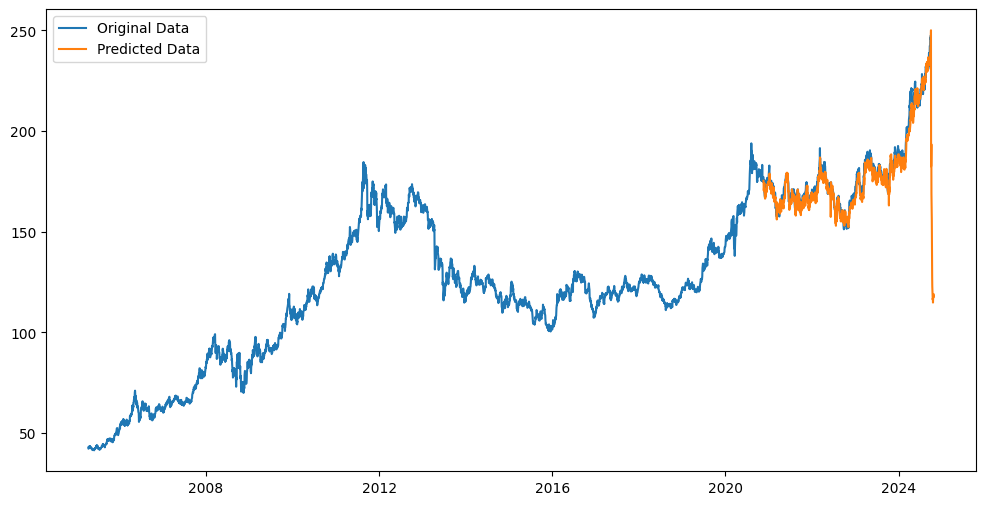

In [19]:
# Prepare data for plotting
# Extend dates for future predictions
future_dates = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=days_ahead, freq='B')
full_dates = stock_data.index.append(future_dates)

# Append future predictions to predicted_data
predicted_data_full = np.concatenate((predicted_data, future_predictions_scaled))
original_data_full = np.concatenate((original_data, [np.nan]*days_ahead))

# Plot the data including future predictions
plt.figure(figsize=(12,6))
plt.plot(full_dates, original_data_full, label='Original Data')
plt.plot(full_dates, predicted_data_full, label='Predicted Data')
plt.legend()
plt.show()

## Lets enable the model to iterate until it doesn't improve after 20 iterations instead of specifying the number of epochs.  Keep the best model.

/home/silwa/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10000], Loss: 0.001648, Test Loss: 0.007468
Epoch [2/10000], Loss: 0.000910, Test Loss: 0.002146
Epoch [3/10000], Loss: 0.001046, Test Loss: 0.001950
Epoch [4/10000], Loss: 0.001040, Test Loss: 0.003579
Epoch [5/10000], Loss: 0.000706, Test Loss: 0.001805
Epoch [6/10000], Loss: 0.000479, Test Loss: 0.002989
Epoch [7/10000], Loss: 0.000649, Test Loss: 0.001421
Epoch [8/10000], Loss: 0.002315, Test Loss: 0.001808
Epoch [9/10000], Loss: 0.000234, Test Loss: 0.002567
Epoch [10/10000], Loss: 0.000444, Test Loss: 0.001534
Epoch [11/10000], Loss: 0.000329, Test Loss: 0.001218
Epoch [12/10000], Loss: 0.001707, Test Loss: 0.003623
Epoch [13/10000], Loss: 0.000281, Test Loss: 0.001161
Epoch [14/10000], Loss: 0.000432, Test Loss: 0.000727
Epoch [15/10000], Loss: 0.000526, Test Loss: 0.001030
Epoch [16/10000], Loss: 0.000958, Test Loss: 0.001413
Epoch [17/10000], Loss: 0.000354, Test Loss: 0.000714
Epoch [18/10000], Loss: 0.000637, Test Loss: 0.000690
Epoch [19/10000], Loss: 0.000620, Tes

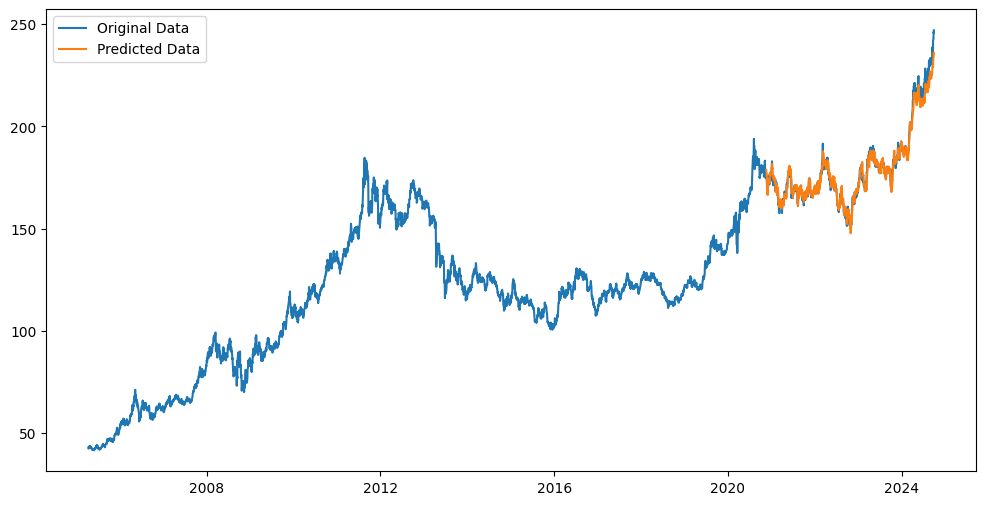

In [20]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from gtda.time_series import TakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

def get_rsi_timeseries(prices, n=1):
    deltas = (prices - prices.shift(1)).fillna(0)

    avg_of_gains = deltas[1:n+1][deltas > 0].sum() / n
    avg_of_losses = -deltas[1:n+1][deltas < 0].sum() / n

    # Set up pd.Series container for RSI values
    rsi_series = pd.Series(0.0, deltas.index)

    # Now calculate RSI using the Wilder smoothing method, starting with n+1 delta.
    up = lambda x: x if x > 0 else 0
    down = lambda x: -x if x < 0 else 0
    i = n+1
    for d in deltas[n+1:]:
        avg_of_gains = ((avg_of_gains * (n-1)) + up(d)) / n
        avg_of_losses = ((avg_of_losses * (n-1)) + down(d)) / n
        if avg_of_losses != 0:
            rs = avg_of_gains / avg_of_losses
            rsi_series.iloc[i] = 100 - (100 / (1 + rs))  # Fix is here
        else:
            rsi_series.iloc[i] = 100  # Fix is here
        i += 1

    return rsi_series
    
def tr(data):
    data['previous_close'] = data['Close'].shift(1)
    data['high-low'] = abs(data['High'] - data['Low'])
    data['high-pc'] = abs(data['High'] - data['previous_close'])
    data['low-pc'] = abs(data['Low'] - data['previous_close'])
    tr = data[['high-low', 'high-pc', 'low-pc']].max(axis=1)
    return tr

def atr(data, period):
    data['tr'] = tr(data)
    atr = data['tr'].rolling(period).mean()
    return atr
    
def supertrend(df, period=7, atr_multiplier=2.5):
    hl2 = (df['High'] + df['Low']) / 2
    df['atr'] = atr(df, period)
    df['upperband'] = hl2 + (atr_multiplier * df['atr'])
    df['lowerband'] = hl2 - (atr_multiplier * df['atr'])
    df['in_uptrend'] = 1

    for current in range(1, len(df.index)):
        previous = current - 1

        if df['Close'].iloc[current] > df['upperband'].iloc[previous]:
            df.loc[df.index[current], 'in_uptrend'] = 1
        elif df['Close'].iloc[current] < df['lowerband'].iloc[previous]:
            df.loc[df.index[current], 'in_uptrend'] = 0
        else:
            df.loc[df.index[current], 'in_uptrend'] = df.loc[df.index[previous], 'in_uptrend']

            if df['in_uptrend'].iloc[current] and df['lowerband'].iloc[current] < df['lowerband'].iloc[previous]:
                df.loc[df.index[current], 'lowerband'] = df.loc[df.index[previous], 'lowerband']

            if not df['in_uptrend'].iloc[current] and df['upperband'].iloc[current] > df['upperband'].iloc[previous]:
                df.loc[df.index[current], 'upperband'] = df.loc[df.index[previous], 'upperband']
        
    return df
    
def calculate_technical_indicators(df):
    # Bollinger Bands
    df['20_day_SMA'] = df['Adj Close'].rolling(window=20).mean()
    df['20_day_STD'] = df['Adj Close'].rolling(window=20).std()
    df['Upper_Band'] = df['20_day_SMA'] + (df['20_day_STD'] * 2)
    df['Lower_Band'] = df['20_day_SMA'] - (df['20_day_STD'] * 2)
    df['Bollinger_Band_Width'] = df['Upper_Band'] - df['Lower_Band']
    
    # MACD
    df['26_ema'] = df['Adj Close'].ewm(span=26).mean()
    df['12_ema'] = df['Adj Close'].ewm(span=12).mean()
    df['MACD'] = df['12_ema'] - df['26_ema']
    df['Signal_Line'] = df['MACD'].ewm(span=9).mean()
    
    # Stochastic Oscillator
    df['14_High'] = df['High'].rolling(14).max()
    df['14_Low'] = df['Low'].rolling(14).min()
    df['%K'] = 100*((df['Close'] - df['14_Low']) / (df['14_High'] - df['14_Low']) )
    df['%D'] = df['%K'].rolling(window=3).mean()
    
    # Williams %R
    df['Williams_%R'] = -100 * (df['14_High'] - df['Close']) / (df['14_High'] - df['14_Low'])
    
    # Accumulation/Distribution Line
    df['CLV'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    df['CLV'] = df['CLV'].fillna(0)  # NaN and inf values will be replaced with 0
    df['ADL'] = (df['CLV'] * df['Volume']).cumsum()
    
    # On Balance Volume
    df['OBV'] = (np.sign(df['Close'].diff()).fillna(0) * df['Volume']).cumsum()
    
    # Historical Volatility
    df['Log_ret'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df['Historical_Volatility'] = df['Log_ret'].rolling(window=252).std() * np.sqrt(252)
    
    # VWAP
    df['Cumulative_Volume_Price'] = (df['Volume'] * df['Adj Close']).cumsum()
    df['Cumulative_Volume'] = df['Volume'].cumsum()
    df['VWAP'] = df['Cumulative_Volume_Price'] / df['Cumulative_Volume']
    df['smaVWAP'] = df['VWAP'].rolling(window=10,min_periods=1).mean()
   
    return df

# Calculate the features
def calculate_features(df):
    df['hlc3'] = (df['Close'] + df['High'] + df['Low']) / 3.0
    df['sma3'] = df['hlc3'].rolling(window=3,min_periods=1).mean()
    df['ema1'] = df['hlc3'].ewm(span=7).mean()
    df['ema2'] = df['hlc3'].ewm(span=16).mean()
    df['ema3'] =  df['hlc3'].ewm(span=25).mean()
    df['MACD'] = (df['ema1'] - df['ema3'])
    df['rsi'] = get_rsi_timeseries(df['Adj Close'], 12)
    df['SMArsi'] = df['rsi'].rolling(window=15,min_periods=1).mean()
    df['drsi'] = df['rsi'] - df['SMArsi']
    df['dSMArsi'] = df['SMArsi'].shift(1).fillna(0).astype(float) - df['SMArsi']
    df['smah4'] = df['High'].rolling(window=4,min_periods=1).mean()
    df['smal4'] = df['Low'].rolling(window=4,min_periods=1).mean()
    df['dsmah4'] = df['Adj Close'] - df['smah4']
    
    # Create Bollinger Bands
    df['sma10'] = df['Adj Close'].rolling(window=10,min_periods=1).mean()
    
    # tech indicators
    df = calculate_technical_indicators(df)
    
    df = supertrend(df)
    df['kst'] = df['sma3'] - df['ema1'] + df['sma3'] - df['ema2'] + df['sma3'] - df['ema3']
    df['SMAkst'] = df['kst'].rolling(window=15,min_periods=1).mean()
    df['dkst'] = df['SMAkst'] - df['kst']
    df['wema1'] = df['hlc3'] - df['ema1']
    df['wema2'] = df['hlc3'] - df['ema2']
    df['wema3'] = df['hlc3'] - df['ema3']
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.fillna(0)
    
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index

    return df

# Download stock data
stock_data =stock_data_orig

stock_data = calculate_features(stock_data)  # Assuming you have a function to calculate other features

# List of features (including 'Adj Close')
FEATURE_COLUMNS = ["Adj Close", "hlc3", "ema1", "ema2", "ema3", "rsi", "SMArsi"]

# Drop any rows with NaN values (optional depending on your data)
stock_data.dropna(inplace=True)

# Define your time_step (days_back) if not defined
# Define the number of days ahead you want to predict
days_back = 50  # Adjust as needed
days_ahead = 20  # Adjust as needed

# ------------------------ #
# Part 1: TDA Feature Engineering
# ------------------------ #

# Prepare the time series windows for TDA feature extraction
adj_close = stock_data['Adj Close'].values

# Parameters for windowing
window_size = 100  # Adjust as needed
window_stride = 1  # Adjust as needed

def create_time_series_windows(data, window_size, stride):
    windows = []
    indices = []
    for i in range(0, len(data) - window_size + 1, stride):
        windows.append(data[i:i+window_size])
        indices.append(i)
    return np.array(windows), indices

time_series_windows, window_indices = create_time_series_windows(adj_close, window_size, window_stride)

# Set up the TDA pipeline
embedding_dimension = 30  # Adjust as needed
embedding_time_delay = 1  # Adjust as needed

embedder = TakensEmbedding(time_delay=embedding_time_delay,
                           dimension=embedding_dimension,
                           stride=1)  # Since our windows are already sampled

batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)

persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)

scaling = Scaler()

entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)

steps = [("embedder", embedder),
         ("pca", batch_pca),
         ("persistence", persistence),
         ("scaling", scaling),
         ("entropy", entropy)]

topological_transformer = Pipeline(steps)

# Apply the pipeline to time_series_windows
features = topological_transformer.fit_transform(time_series_windows)

# Create DataFrame with features and timestamps
timestamps = stock_data.index.values

# Align features with corresponding timestamps
feature_timestamps = [timestamps[i + window_size - 1] for i in window_indices]

features_df = pd.DataFrame(features, index=feature_timestamps, columns=['entropy_H0', 'entropy_H1'])

# Merge features_df into stock_data
stock_data = stock_data.merge(features_df, how='left', left_index=True, right_index=True)

# Drop NaN values resulting from the merging
stock_data.dropna(inplace=True)

# Update FEATURE_COLUMNS to include the new features
FEATURE_COLUMNS.extend(['entropy_H0', 'entropy_H1'])

# ------------------------ #
# Part 2: Scaling Features
# ------------------------ #

# Scale each feature individually
scalers = {}
for feature in FEATURE_COLUMNS:
    scalers[feature] = MinMaxScaler(feature_range=(0.05, 0.95))
    stock_data[feature] = scalers[feature].fit_transform(stock_data[feature].values.reshape(-1, 1))

# ------------------------ #
# Part 3: Prepare Dataset and Model Training
# ------------------------ #

# Create the dataset with multiple features
def create_multifeature_dataset(data, features, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[features].values[i:(i + time_step)])  # Multi-feature input
        y.append(data['Adj Close'].values[i + time_step])       # Predicting close price
    return np.array(X), np.array(y)

time_step = days_back
X, y = create_multifeature_dataset(stock_data, FEATURE_COLUMNS, time_step)

# Split into training and testing sets
train_size = 0.8
train_size_int = int(X.shape[0] * train_size)
X_train, X_test = X[:train_size_int], X[train_size_int:]
y_train, y_test = y[:train_size_int], y[train_size_int:]

# Convert to torch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# ------------------------ #
# Part 4: Define Model (Assuming Encoder, Decoder, Transformer are defined)
# ------------------------ #
# Update Encoder and Decoder to handle multiple features
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(Encoder, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder2 = nn.Sequential(
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder3 = nn.Sequential(
            nn.Conv1d(hidden_channels * 2, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 4, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc1_pooled = self.pool1(enc1)
        enc2 = self.encoder2(enc1_pooled)
        enc2_pooled = self.pool2(enc2)
        enc3 = self.encoder3(enc2_pooled)
        enc3_pooled = self.pool3(enc3)
        return enc1, enc2, enc3, enc3_pooled

class Decoder(nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super(Decoder, self).__init__()

        self.up3 = nn.ConvTranspose1d(
            hidden_channels * 4,  # in_channels (256)
            hidden_channels * 4,  # out_channels (256)
            kernel_size=2,
            stride=2,
            # Remove output_padding to let the layer compute the necessary size
        )

        self.decoder3 = nn.Sequential(
            nn.Conv1d(hidden_channels * 8, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 4, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
        )

        self.up2 = nn.ConvTranspose1d(
            hidden_channels * 4,  # in_channels (256)
            hidden_channels * 2,  # out_channels (128)
            kernel_size=2,
            stride=2
        )

        self.decoder2 = nn.Sequential(
            nn.Conv1d(hidden_channels * 4, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
        )

        self.up1 = nn.ConvTranspose1d(
            hidden_channels * 2,  # in_channels (128)
            hidden_channels,      # out_channels (64)
            kernel_size=2,
            stride=2
        )

        self.decoder1 = nn.Sequential(
            nn.Conv1d(hidden_channels * 2, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
        )

        self.final_conv = nn.Conv1d(hidden_channels, out_channels, kernel_size=1)

    def forward(self, enc1, enc2, enc3, bottleneck):
        up3 = self.up3(bottleneck)  # Upsample

        # Adjust sequence lengths to match for concatenation
        diff3 = up3.size(2) - enc3.size(2)
        if diff3 > 0:
            up3 = up3[:, :, :-diff3]
        elif diff3 < 0:
            enc3 = enc3[:, :, :-(-diff3)]
        dec3 = torch.cat((up3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        up2 = self.up2(dec3)
        diff2 = up2.size(2) - enc2.size(2)
        if diff2 > 0:
            up2 = up2[:, :, :-diff2]
        elif diff2 < 0:
            enc2 = enc2[:, :, :-(-diff2)]
        dec2 = torch.cat((up2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        up1 = self.up1(dec2)
        diff1 = up1.size(2) - enc1.size(2)
        if diff1 > 0:
            up1 = up1[:, :, :-diff1]
        elif diff1 < 0:
            enc1 = enc1[:, :, :-(-diff1)]
        dec1 = torch.cat((up1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        output = self.final_conv(dec1)
        return output

# Define the Transformer Bottleneck
class TransformerBottleneck(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, dim_feedforward):
        super(TransformerBottleneck, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        # x shape: (batch_size, channels, seq_len)
        # Need to permute to (seq_len, batch_size, channels)
        x = x.permute(2, 0, 1)
        x = self.transformer(x)
        # Permute back to (batch_size, channels, seq_len)
        x = x.permute(1, 2, 0)
        return x

# Define the complete model
class UNetWithTransformer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(UNetWithTransformer, self).__init__()
        self.encoder = Encoder(in_channels, hidden_channels)
        self.transformer = TransformerBottleneck(input_dim=hidden_channels * 4, nhead=8, num_layers=4, dim_feedforward=512)
        self.decoder = Decoder(hidden_channels, out_channels)

    def forward(self, x):
        # Permute x to (batch_size, num_features, time_steps) for Conv1d
        x = x.permute(0, 2, 1)
        
        # Pass through the encoder, transformer, and decoder
        enc1, enc2, enc3, bottleneck = self.encoder(x)
        bottleneck = self.transformer(bottleneck)
        output = self.decoder(enc1, enc2, enc3, bottleneck)
        # For regression, take the last time step
        output = output[:, :, -1]
        return output.squeeze()

# Instantiate the model
model = UNetWithTransformer(in_channels=len(FEATURE_COLUMNS), hidden_channels=16, out_channels=1).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ------------------------ #
# Part 5: Training Loop (Modified)
# ------------------------ #

num_epochs = 10000
best_test_loss = float('inf')
patience_counter = 0

for epoch in range(1, num_epochs + 1):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    # Evaluate test loss after each epoch
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
    
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}, Test Loss: {test_loss.item():.6f}')
    
    # Check for improvement
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= 50:
        print(f'Early stopping at epoch {epoch}')
        break

# ------------------------ #
# Part 6: Evaluation and Forecasting
# ------------------------ #

# Evaluate test loss (already evaluated during training)

# Make predictions on X_test
with torch.no_grad():
    test_predictions = model(X_test)
    test_predictions = test_predictions.cpu().detach().numpy()
    test_predictions_scaled = scalers['Adj Close'].inverse_transform(test_predictions.reshape(-1, 1))

# Prepare data for plotting
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(test_predictions_scaled):] = test_predictions_scaled.reshape(-1)

# Plot original data and predicted data
plt.figure(figsize=(12,6))
plt.plot(stock_data.index, original_data, label='Original Data')
plt.plot(stock_data.index, predicted_data, label='Predicted Data')
plt.legend()
plt.show()



# Initialize a list to store future predictions
future_predictions_scaled = []

# Start with the last available input sequence from your data
last_sequence = X_test[-1].cpu().numpy()  # Shape: (time_step, num_features)

# Loop to predict each future day iteratively
for _ in range(days_ahead):
    # Convert last_sequence to tensor and move to device
    input_seq = torch.from_numpy(last_sequence).unsqueeze(0).float().to(device)  # Shape: (1, time_step, num_features)
    
    # Make prediction
    with torch.no_grad():
        pred = model(input_seq)
    
    # Ensure pred is a tensor of shape (1,)
    if pred.dim() == 0:
        pred = pred.unsqueeze(0)
    
    # Convert prediction to NumPy array
    pred_np = pred.cpu().numpy()  # Shape: (1,)
    
    # Inverse transform the prediction
    pred_scaled = scalers['Adj Close'].inverse_transform(pred_np.reshape(-1, 1))[0][0]
    
    # Append prediction to the list
    future_predictions_scaled.append(pred_scaled)
    
    # Prepare the new features for the next time step
    new_features = np.zeros((1, len(FEATURE_COLUMNS)))
    
    # Update 'Adj Close' with the predicted normalized value
    pred_scaled_norm = scalers['Adj Close'].transform(pred_np.reshape(-1, 1))[0][0]
    new_features[0][FEATURE_COLUMNS.index('Adj Close')] = pred_scaled_norm
    
    # For other features, either keep them constant or update if possible
    for idx, feature in enumerate(FEATURE_COLUMNS):
        if feature == 'Adj Close':
            continue
        elif feature in ['hlc3', 'ema1', 'ema2', 'ema3', 'rsi', 'VWAP', 'smaVWAP', 'SMAkst']:
            # You can attempt to update these features if you have formulas
            # For now, we'll keep them the same as the last known values
            new_features[0][idx] = last_sequence[-1][idx]
        elif feature in ['entropy_H0', 'entropy_H1']:
            # Keep TDA features constant
            new_features[0][idx] = last_sequence[-1][idx]
        else:
            # For any other features, keep the last known value
            new_features[0][idx] = last_sequence[-1][idx]
    
    # Update last_sequence
    last_sequence = np.vstack((last_sequence[1:], new_features))

# Prepare data for plotting
# Extend dates for future predictions
future_dates = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=days_ahead, freq='B')
full_dates = stock_data.index.append(future_dates)

# Append future predictions to predicted_data
predicted_data_full = np.concatenate((predicted_data, future_predictions_scaled))
original_data_full = np.concatenate((original_data, [np.nan]*days_ahead))

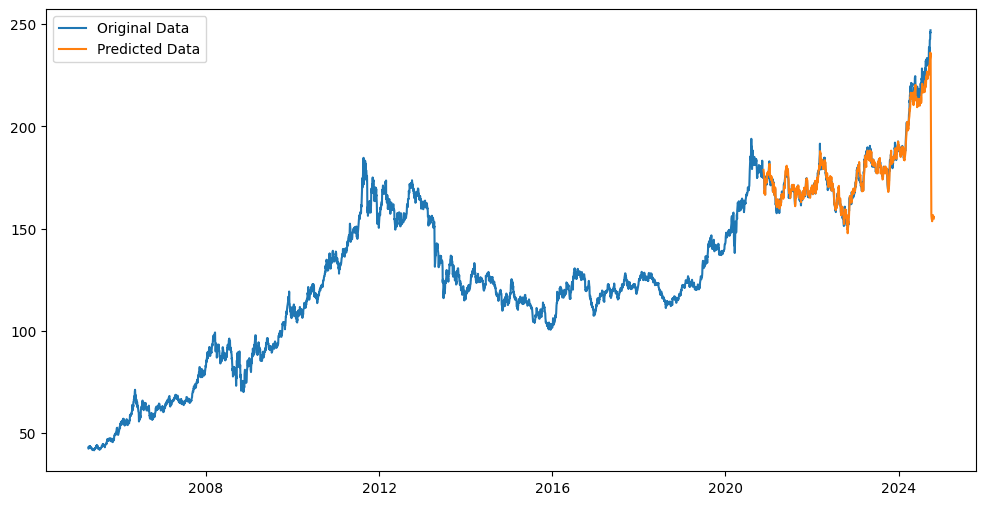

In [21]:
# Plot the data including future predictions
plt.figure(figsize=(12,6))
plt.plot(full_dates, original_data_full, label='Original Data')
plt.plot(full_dates, predicted_data_full, label='Predicted Data')
plt.legend()
plt.show()

## Enable fast grokking (generalization) and custom assymetric loss function
https://pair.withgoogle.com/explorables/grokking/#:~:text=This%20phenomenon%20%E2%80%93%20where%20generalization%20seems,sparked%20a%20flurry%20of%20interest%20.
github repo: https://github.com/ironjr/grokfast

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf

# grokfast is local file
from grokfast import gradfilter_ma, gradfilter_ema
from gtda.time_series import TakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

/home/silwa/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10000], Loss: 0.008979, Test Loss: 0.012953
Epoch [2/10000], Loss: 0.000734, Test Loss: 0.003111
Epoch [3/10000], Loss: 0.001295, Test Loss: 0.003285
Epoch [4/10000], Loss: 0.000957, Test Loss: 0.004938
Epoch [5/10000], Loss: 0.000992, Test Loss: 0.001730
Epoch [6/10000], Loss: 0.000959, Test Loss: 0.001526
Epoch [7/10000], Loss: 0.000397, Test Loss: 0.001901
Epoch [8/10000], Loss: 0.000365, Test Loss: 0.001882
Epoch [9/10000], Loss: 0.000501, Test Loss: 0.001966
Epoch [10/10000], Loss: 0.000248, Test Loss: 0.001206
Epoch [11/10000], Loss: 0.000457, Test Loss: 0.001492
Epoch [12/10000], Loss: 0.000911, Test Loss: 0.001798
Epoch [13/10000], Loss: 0.001074, Test Loss: 0.001211
Epoch [14/10000], Loss: 0.001542, Test Loss: 0.001523
Epoch [15/10000], Loss: 0.000308, Test Loss: 0.002694
Epoch [16/10000], Loss: 0.000351, Test Loss: 0.001213
Epoch [17/10000], Loss: 0.000136, Test Loss: 0.001248
Epoch [18/10000], Loss: 0.000489, Test Loss: 0.001671
Epoch [19/10000], Loss: 0.000409, Tes

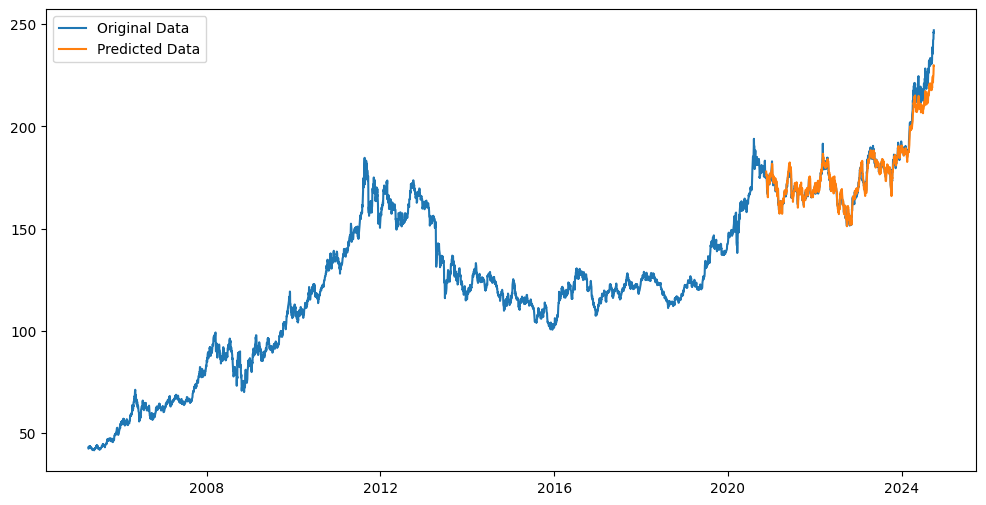

In [23]:
def get_rsi_timeseries(prices, n=1):
    deltas = (prices - prices.shift(1)).fillna(0)

    avg_of_gains = deltas[1:n+1][deltas > 0].sum() / n
    avg_of_losses = -deltas[1:n+1][deltas < 0].sum() / n

    # Set up pd.Series container for RSI values
    rsi_series = pd.Series(0.0, deltas.index)

    # Now calculate RSI using the Wilder smoothing method, starting with n+1 delta.
    up = lambda x: x if x > 0 else 0
    down = lambda x: -x if x < 0 else 0
    i = n+1
    for d in deltas[n+1:]:
        avg_of_gains = ((avg_of_gains * (n-1)) + up(d)) / n
        avg_of_losses = ((avg_of_losses * (n-1)) + down(d)) / n
        if avg_of_losses != 0:
            rs = avg_of_gains / avg_of_losses
            rsi_series.iloc[i] = 100 - (100 / (1 + rs))  # Fix is here
        else:
            rsi_series.iloc[i] = 100  # Fix is here
        i += 1

    return rsi_series
    
def tr(data):
    data['previous_close'] = data['Close'].shift(1)
    data['high-low'] = abs(data['High'] - data['Low'])
    data['high-pc'] = abs(data['High'] - data['previous_close'])
    data['low-pc'] = abs(data['Low'] - data['previous_close'])
    tr = data[['high-low', 'high-pc', 'low-pc']].max(axis=1)
    return tr

def atr(data, period):
    data['tr'] = tr(data)
    atr = data['tr'].rolling(period).mean()
    return atr
    
def supertrend(df, period=7, atr_multiplier=2.5):
    hl2 = (df['High'] + df['Low']) / 2
    df['atr'] = atr(df, period)
    df['upperband'] = hl2 + (atr_multiplier * df['atr'])
    df['lowerband'] = hl2 - (atr_multiplier * df['atr'])
    df['in_uptrend'] = 1

    for current in range(1, len(df.index)):
        previous = current - 1

        if df['Close'].iloc[current] > df['upperband'].iloc[previous]:
            df.loc[df.index[current], 'in_uptrend'] = 1
        elif df['Close'].iloc[current] < df['lowerband'].iloc[previous]:
            df.loc[df.index[current], 'in_uptrend'] = 0
        else:
            df.loc[df.index[current], 'in_uptrend'] = df.loc[df.index[previous], 'in_uptrend']

            if df['in_uptrend'].iloc[current] and df['lowerband'].iloc[current] < df['lowerband'].iloc[previous]:
                df.loc[df.index[current], 'lowerband'] = df.loc[df.index[previous], 'lowerband']

            if not df['in_uptrend'].iloc[current] and df['upperband'].iloc[current] > df['upperband'].iloc[previous]:
                df.loc[df.index[current], 'upperband'] = df.loc[df.index[previous], 'upperband']
        
    return df
    
def calculate_technical_indicators(df):
    # Bollinger Bands
    df['20_day_SMA'] = df['Adj Close'].rolling(window=20).mean()
    df['20_day_STD'] = df['Adj Close'].rolling(window=20).std()
    df['Upper_Band'] = df['20_day_SMA'] + (df['20_day_STD'] * 2)
    df['Lower_Band'] = df['20_day_SMA'] - (df['20_day_STD'] * 2)
    df['Bollinger_Band_Width'] = df['Upper_Band'] - df['Lower_Band']
    
    # MACD
    df['26_ema'] = df['Adj Close'].ewm(span=26).mean()
    df['12_ema'] = df['Adj Close'].ewm(span=12).mean()
    df['MACD'] = df['12_ema'] - df['26_ema']
    df['Signal_Line'] = df['MACD'].ewm(span=9).mean()
    
    # Stochastic Oscillator
    df['14_High'] = df['High'].rolling(14).max()
    df['14_Low'] = df['Low'].rolling(14).min()
    df['%K'] = 100*((df['Close'] - df['14_Low']) / (df['14_High'] - df['14_Low']) )
    df['%D'] = df['%K'].rolling(window=3).mean()
    
    # Williams %R
    df['Williams_%R'] = -100 * (df['14_High'] - df['Close']) / (df['14_High'] - df['14_Low'])
    
    # Accumulation/Distribution Line
    df['CLV'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    df['CLV'] = df['CLV'].fillna(0)  # NaN and inf values will be replaced with 0
    df['ADL'] = (df['CLV'] * df['Volume']).cumsum()
    
    # On Balance Volume
    df['OBV'] = (np.sign(df['Close'].diff()).fillna(0) * df['Volume']).cumsum()
    
    # Historical Volatility
    df['Log_ret'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df['Historical_Volatility'] = df['Log_ret'].rolling(window=252).std() * np.sqrt(252)
    
    # VWAP
    df['Cumulative_Volume_Price'] = (df['Volume'] * df['Adj Close']).cumsum()
    df['Cumulative_Volume'] = df['Volume'].cumsum()
    df['VWAP'] = df['Cumulative_Volume_Price'] / df['Cumulative_Volume']
    df['smaVWAP'] = df['VWAP'].rolling(window=10,min_periods=1).mean()
   
    return df

# Calculate the features
def calculate_features(df):
    df['hlc3'] = (df['Close'] + df['High'] + df['Low']) / 3.0
    df['sma3'] = df['hlc3'].rolling(window=3,min_periods=1).mean()
    df['ema1'] = df['hlc3'].ewm(span=7).mean()
    df['ema2'] = df['hlc3'].ewm(span=16).mean()
    df['ema3'] =  df['hlc3'].ewm(span=25).mean()
    df['MACD'] = (df['ema1'] - df['ema3'])
    df['rsi'] = get_rsi_timeseries(df['Adj Close'], 12)
    df['SMArsi'] = df['rsi'].rolling(window=15,min_periods=1).mean()
    df['drsi'] = df['rsi'] - df['SMArsi']
    df['dSMArsi'] = df['SMArsi'].shift(1).fillna(0).astype(float) - df['SMArsi']
    df['smah4'] = df['High'].rolling(window=4,min_periods=1).mean()
    df['smal4'] = df['Low'].rolling(window=4,min_periods=1).mean()
    df['dsmah4'] = df['Adj Close'] - df['smah4']
    
    # Create Bollinger Bands
    df['sma10'] = df['Adj Close'].rolling(window=10,min_periods=1).mean()
    
    # tech indicators
    df = calculate_technical_indicators(df)
    
    df = supertrend(df)
    df['kst'] = df['sma3'] - df['ema1'] + df['sma3'] - df['ema2'] + df['sma3'] - df['ema3']
    df['SMAkst'] = df['kst'].rolling(window=15,min_periods=1).mean()
    df['dkst'] = df['SMAkst'] - df['kst']
    df['wema1'] = df['hlc3'] - df['ema1']
    df['wema2'] = df['hlc3'] - df['ema2']
    df['wema3'] = df['hlc3'] - df['ema3']
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.fillna(0)
    
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index

    return df

# Download stock data
stock_data =stock_data_orig

stock_data = calculate_features(stock_data)  # Assuming you have a function to calculate other features

# List of features (including 'Adj Close')
FEATURE_COLUMNS = ["Adj Close", "hlc3", "ema1", "ema2", "ema3", "rsi", "SMArsi"]

# Drop any rows with NaN values (optional depending on your data)
stock_data.dropna(inplace=True)

# Define the number of days ahead you want to predict
days_ahead = 20  # Adjust as needed
days_back = 50  # Adjust as needed

# ------------------------ #
# Part 1: TDA Feature Engineering
# ------------------------ #

# Prepare the time series windows for TDA feature extraction
adj_close = stock_data['Adj Close'].values

# Parameters for windowing
window_size = 100  # Adjust as needed
window_stride = 1  # Adjust as needed

def create_time_series_windows(data, window_size, stride):
    windows = []
    indices = []
    for i in range(0, len(data) - window_size + 1, stride):
        windows.append(data[i:i+window_size])
        indices.append(i)
    return np.array(windows), indices

time_series_windows, window_indices = create_time_series_windows(adj_close, window_size, window_stride)

# Set up the TDA pipeline
embedding_dimension = 30  # Adjust as needed
embedding_time_delay = 1  # Adjust as needed

embedder = TakensEmbedding(time_delay=embedding_time_delay,
                           dimension=embedding_dimension,
                           stride=1)  # Since our windows are already sampled

batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)

persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)

scaling = Scaler()

entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)

steps = [("embedder", embedder),
         ("pca", batch_pca),
         ("persistence", persistence),
         ("scaling", scaling),
         ("entropy", entropy)]

topological_transformer = Pipeline(steps)

# Apply the pipeline to time_series_windows
features = topological_transformer.fit_transform(time_series_windows)

# Create DataFrame with features and timestamps
timestamps = stock_data.index.values

# Align features with corresponding timestamps
feature_timestamps = [timestamps[i + window_size - 1] for i in window_indices]

features_df = pd.DataFrame(features, index=feature_timestamps, columns=['entropy_H0', 'entropy_H1'])

# Merge features_df into stock_data
stock_data = stock_data.merge(features_df, how='left', left_index=True, right_index=True)

# Drop NaN values resulting from the merging
stock_data.dropna(inplace=True)

# Update FEATURE_COLUMNS to include the new features
FEATURE_COLUMNS.extend(['entropy_H0', 'entropy_H1'])

# ------------------------ #
# Part 2: Scaling Features
# ------------------------ #

# Scale each feature individually
scalers = {}
for feature in FEATURE_COLUMNS:
    scalers[feature] = MinMaxScaler(feature_range=(0.05, 0.95))
    stock_data[feature] = scalers[feature].fit_transform(stock_data[feature].values.reshape(-1, 1))

# ------------------------ #
# Part 3: Prepare Dataset and Model Training
# ------------------------ #

# Create the dataset with multiple features
def create_multifeature_dataset(data, features, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[features].values[i:(i + time_step)])  # Multi-feature input
        y.append(data['Adj Close'].values[i + time_step])       # Predicting close price
    return np.array(X), np.array(y)

# Define your time_step (days_back) if not defined

time_step = days_back
X, y = create_multifeature_dataset(stock_data, FEATURE_COLUMNS, time_step)

# Split into training and testing sets
train_size = 0.8
train_size_int = int(X.shape[0] * train_size)
X_train, X_test = X[:train_size_int], X[train_size_int:]
y_train, y_test = y[:train_size_int], y[train_size_int:]

# Convert to torch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# ------------------------ #
# Part 4: Define Model (Assuming Encoder, Decoder, Transformer are defined)
# ------------------------ #
# Update Encoder and Decoder to handle multiple features
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(Encoder, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder2 = nn.Sequential(
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder3 = nn.Sequential(
            nn.Conv1d(hidden_channels * 2, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 4, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc1_pooled = self.pool1(enc1)
        enc2 = self.encoder2(enc1_pooled)
        enc2_pooled = self.pool2(enc2)
        enc3 = self.encoder3(enc2_pooled)
        enc3_pooled = self.pool3(enc3)
        return enc1, enc2, enc3, enc3_pooled

class Decoder(nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super(Decoder, self).__init__()

        self.up3 = nn.ConvTranspose1d(
            hidden_channels * 4,  # in_channels (256)
            hidden_channels * 4,  # out_channels (256)
            kernel_size=2,
            stride=2,
            # Remove output_padding to let the layer compute the necessary size
        )

        self.decoder3 = nn.Sequential(
            nn.Conv1d(hidden_channels * 8, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 4, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
        )

        self.up2 = nn.ConvTranspose1d(
            hidden_channels * 4,  # in_channels (256)
            hidden_channels * 2,  # out_channels (128)
            kernel_size=2,
            stride=2
        )

        self.decoder2 = nn.Sequential(
            nn.Conv1d(hidden_channels * 4, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
        )

        self.up1 = nn.ConvTranspose1d(
            hidden_channels * 2,  # in_channels (128)
            hidden_channels,      # out_channels (64)
            kernel_size=2,
            stride=2
        )

        self.decoder1 = nn.Sequential(
            nn.Conv1d(hidden_channels * 2, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
        )

        self.final_conv = nn.Conv1d(hidden_channels, out_channels, kernel_size=1)

    def forward(self, enc1, enc2, enc3, bottleneck):
        up3 = self.up3(bottleneck)  # Upsample

        # Adjust sequence lengths to match for concatenation
        diff3 = up3.size(2) - enc3.size(2)
        if diff3 > 0:
            up3 = up3[:, :, :-diff3]
        elif diff3 < 0:
            enc3 = enc3[:, :, :-(-diff3)]
        dec3 = torch.cat((up3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        up2 = self.up2(dec3)
        diff2 = up2.size(2) - enc2.size(2)
        if diff2 > 0:
            up2 = up2[:, :, :-diff2]
        elif diff2 < 0:
            enc2 = enc2[:, :, :-(-diff2)]
        dec2 = torch.cat((up2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        up1 = self.up1(dec2)
        diff1 = up1.size(2) - enc1.size(2)
        if diff1 > 0:
            up1 = up1[:, :, :-diff1]
        elif diff1 < 0:
            enc1 = enc1[:, :, :-(-diff1)]
        dec1 = torch.cat((up1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        output = self.final_conv(dec1)
        return output

# Define the Transformer Bottleneck
class TransformerBottleneck(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, dim_feedforward):
        super(TransformerBottleneck, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        # x shape: (batch_size, channels, seq_len)
        # Need to permute to (seq_len, batch_size, channels)
        x = x.permute(2, 0, 1)
        x = self.transformer(x)
        # Permute back to (batch_size, channels, seq_len)
        x = x.permute(1, 2, 0)
        return x

# Define the complete model
class UNetWithTransformer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(UNetWithTransformer, self).__init__()
        self.encoder = Encoder(in_channels, hidden_channels)
        self.transformer = TransformerBottleneck(input_dim=hidden_channels * 4, nhead=8, num_layers=4, dim_feedforward=512)
        self.decoder = Decoder(hidden_channels, out_channels)

    def forward(self, x):
        # Permute x to (batch_size, num_features, time_steps) for Conv1d
        x = x.permute(0, 2, 1)
        
        # Pass through the encoder, transformer, and decoder
        enc1, enc2, enc3, bottleneck = self.encoder(x)
        bottleneck = self.transformer(bottleneck)
        output = self.decoder(enc1, enc2, enc3, bottleneck)
        # For regression, take the last time step
        output = output[:, :, -1]
        return output.squeeze()

# Instantiate the model
model = UNetWithTransformer(in_channels=len(FEATURE_COLUMNS), hidden_channels=16, out_channels=1).to(device)

# Define loss function and optimizer
#criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define custom loss function
class AsymmetricLoss(nn.Module):
    def __init__(self, alpha=1.5):
        super(AsymmetricLoss, self).__init__()
        self.alpha = alpha
        
    def forward(self, outputs, targets):
        errors = outputs - targets
        loss = torch.where(errors >= 0, errors**2, self.alpha * errors**2)
        return loss.mean()

criterion = AsymmetricLoss(alpha=1.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ------------------------ #
# Part 5: Training Loop (Modified)
# ------------------------ #

num_epochs = 10000
best_test_loss = float('inf')
patience_counter = 0

# for fast grokking
grads = None
for epoch in range(1, num_epochs + 1):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        # for fast grokking
        grads = gradfilter_ema(model, grads=grads, alpha=.98, lamb=2.0)
        optimizer.step()
    
    # Evaluate test loss after each epoch
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
    
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}, Test Loss: {test_loss.item():.6f}')
    
    # Check for improvement
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= 50:
        print(f'Early stopping at epoch {epoch}')
        break

# ------------------------ #
# Part 6: Evaluation and Forecasting
# ------------------------ #

# Evaluate test loss (already evaluated during training)

# Make predictions on X_test
with torch.no_grad():
    test_predictions = model(X_test)
    test_predictions = test_predictions.cpu().detach().numpy()
    test_predictions_scaled = scalers['Adj Close'].inverse_transform(test_predictions.reshape(-1, 1))

# Prepare data for plotting
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(test_predictions_scaled):] = test_predictions_scaled.reshape(-1)

# Plot original data and predicted data
plt.figure(figsize=(12,6))
plt.plot(stock_data.index, original_data, label='Original Data')
plt.plot(stock_data.index, predicted_data, label='Predicted Data')
plt.legend()
plt.show()

# Initialize a list to store future predictions
future_predictions_scaled = []

# Start with the last available input sequence from your data
last_sequence = X_test[-1].cpu().numpy()  # Shape: (time_step, num_features)

# Loop to predict each future day iteratively
for _ in range(days_ahead):
    # Convert last_sequence to tensor and move to device
    input_seq = torch.from_numpy(last_sequence).unsqueeze(0).float().to(device)  # Shape: (1, time_step, num_features)
    
    # Make prediction
    with torch.no_grad():
        pred = model(input_seq)
    
    # Ensure pred is a tensor of shape (1,)
    if pred.dim() == 0:
        pred = pred.unsqueeze(0)
    
    # Convert prediction to NumPy array
    pred_np = pred.cpu().numpy()  # Shape: (1,)
    
    # Inverse transform the prediction
    pred_scaled = scalers['Adj Close'].inverse_transform(pred_np.reshape(-1, 1))[0][0]
    
    # Append prediction to the list
    future_predictions_scaled.append(pred_scaled)
    
    # Prepare the new features for the next time step
    new_features = np.zeros((1, len(FEATURE_COLUMNS)))
    
    # Update 'Adj Close' with the predicted normalized value
    pred_scaled_norm = scalers['Adj Close'].transform(pred_np.reshape(-1, 1))[0][0]
    new_features[0][FEATURE_COLUMNS.index('Adj Close')] = pred_scaled_norm
    
    # For other features, either keep them constant or update if possible
    for idx, feature in enumerate(FEATURE_COLUMNS):
        if feature == 'Adj Close':
            continue
        elif feature in ['hlc3', 'ema1', 'ema2', 'ema3', 'rsi', 'VWAP', 'smaVWAP', 'SMAkst']:
            # You can attempt to update these features if you have formulas
            # For now, we'll keep them the same as the last known values
            new_features[0][idx] = last_sequence[-1][idx]
        elif feature in ['entropy_H0', 'entropy_H1']:
            # Keep TDA features constant
            new_features[0][idx] = last_sequence[-1][idx]
        else:
            # For any other features, keep the last known value
            new_features[0][idx] = last_sequence[-1][idx]
    
    # Update last_sequence
    last_sequence = np.vstack((last_sequence[1:], new_features))

# Prepare data for plotting
# Extend dates for future predictions
future_dates = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=days_ahead, freq='B')
full_dates = stock_data.index.append(future_dates)

# Append future predictions to predicted_data
predicted_data_full = np.concatenate((predicted_data, future_predictions_scaled))
original_data_full = np.concatenate((original_data, [np.nan]*days_ahead))

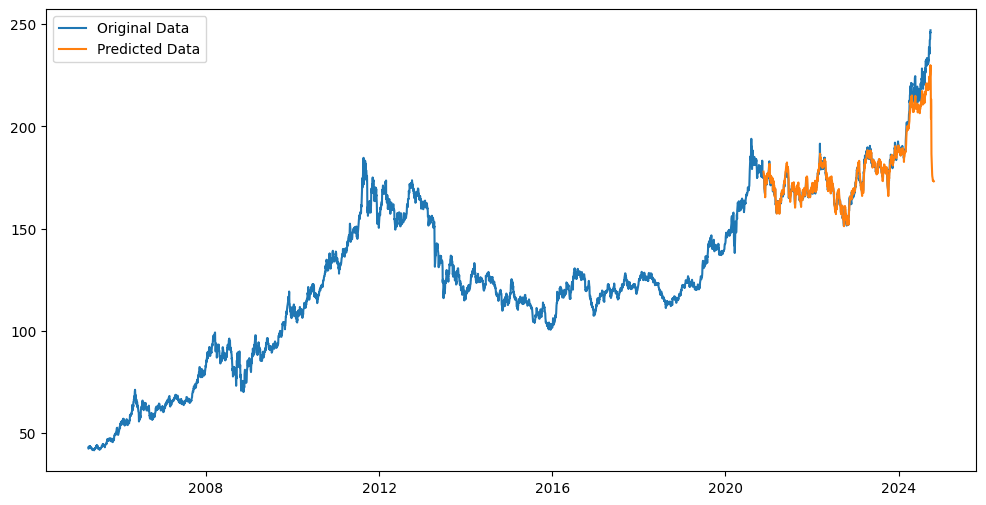

In [24]:
# Plot the data including future predictions
plt.figure(figsize=(12,6))
plt.plot(full_dates, original_data_full, label='Original Data')
plt.plot(full_dates, predicted_data_full, label='Predicted Data')
plt.legend()
plt.show()

## Improved loss function to punish forecast in wrong direction

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf

# grokfast is local file
from grokfast import gradfilter_ma, gradfilter_ema
from gtda.time_series import TakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

/home/silwa/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10000], Loss: 0.008346, Test Loss: 0.120725
Epoch [2/10000], Loss: 0.001684, Test Loss: 0.048464
Epoch [3/10000], Loss: 0.003763, Test Loss: 0.007629
Epoch [4/10000], Loss: 0.003322, Test Loss: 0.005166
Epoch [5/10000], Loss: 0.001092, Test Loss: 0.001226
Epoch [6/10000], Loss: 0.001093, Test Loss: 0.000601
Epoch [7/10000], Loss: 0.002177, Test Loss: 0.000572
Epoch [8/10000], Loss: 0.000414, Test Loss: 0.000513
Epoch [9/10000], Loss: 0.001894, Test Loss: 0.000770
Epoch [10/10000], Loss: 0.001454, Test Loss: 0.000512
Epoch [11/10000], Loss: 0.001607, Test Loss: 0.000664
Epoch [12/10000], Loss: 0.000437, Test Loss: 0.000540
Epoch [13/10000], Loss: 0.001235, Test Loss: 0.000523
Epoch [14/10000], Loss: 0.000263, Test Loss: 0.000507
Epoch [15/10000], Loss: 0.001004, Test Loss: 0.000421
Epoch [16/10000], Loss: 0.000345, Test Loss: 0.000975
Epoch [17/10000], Loss: 0.000431, Test Loss: 0.000516
Epoch [18/10000], Loss: 0.000709, Test Loss: 0.000555
Epoch [19/10000], Loss: 0.000602, Tes

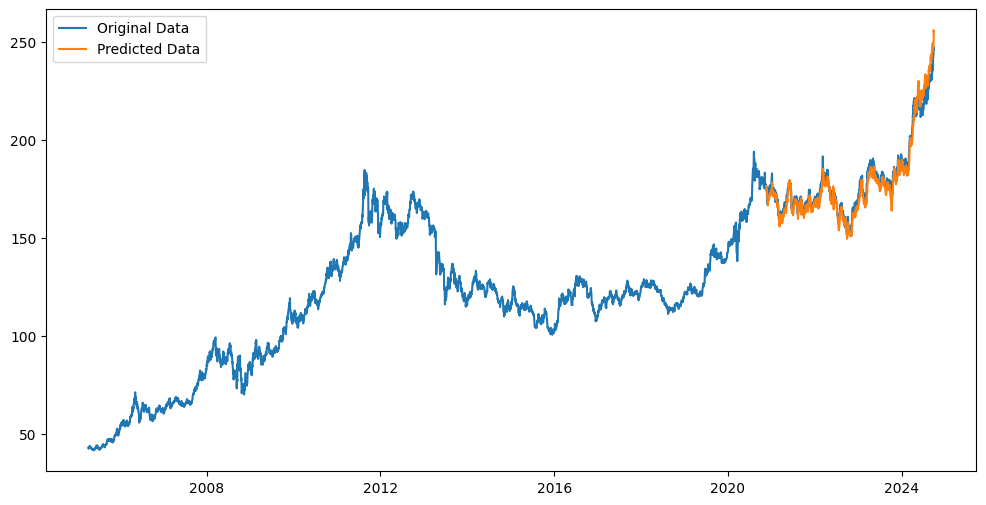

In [28]:
def get_rsi_timeseries(prices, n=1):
    deltas = (prices - prices.shift(1)).fillna(0)

    avg_of_gains = deltas[1:n+1][deltas > 0].sum() / n
    avg_of_losses = -deltas[1:n+1][deltas < 0].sum() / n

    # Set up pd.Series container for RSI values
    rsi_series = pd.Series(0.0, deltas.index)

    # Now calculate RSI using the Wilder smoothing method, starting with n+1 delta.
    up = lambda x: x if x > 0 else 0
    down = lambda x: -x if x < 0 else 0
    i = n+1
    for d in deltas[n+1:]:
        avg_of_gains = ((avg_of_gains * (n-1)) + up(d)) / n
        avg_of_losses = ((avg_of_losses * (n-1)) + down(d)) / n
        if avg_of_losses != 0:
            rs = avg_of_gains / avg_of_losses
            rsi_series.iloc[i] = 100 - (100 / (1 + rs))  # Fix is here
        else:
            rsi_series.iloc[i] = 100  # Fix is here
        i += 1

    return rsi_series
    
def tr(data):
    data['previous_close'] = data['Close'].shift(1)
    data['high-low'] = abs(data['High'] - data['Low'])
    data['high-pc'] = abs(data['High'] - data['previous_close'])
    data['low-pc'] = abs(data['Low'] - data['previous_close'])
    tr = data[['high-low', 'high-pc', 'low-pc']].max(axis=1)
    return tr

def atr(data, period):
    data['tr'] = tr(data)
    atr = data['tr'].rolling(period).mean()
    return atr
    
def supertrend(df, period=7, atr_multiplier=2.5):
    hl2 = (df['High'] + df['Low']) / 2
    df['atr'] = atr(df, period)
    df['upperband'] = hl2 + (atr_multiplier * df['atr'])
    df['lowerband'] = hl2 - (atr_multiplier * df['atr'])
    df['in_uptrend'] = 1

    for current in range(1, len(df.index)):
        previous = current - 1

        if df['Close'].iloc[current] > df['upperband'].iloc[previous]:
            df.loc[df.index[current], 'in_uptrend'] = 1
        elif df['Close'].iloc[current] < df['lowerband'].iloc[previous]:
            df.loc[df.index[current], 'in_uptrend'] = 0
        else:
            df.loc[df.index[current], 'in_uptrend'] = df.loc[df.index[previous], 'in_uptrend']

            if df['in_uptrend'].iloc[current] and df['lowerband'].iloc[current] < df['lowerband'].iloc[previous]:
                df.loc[df.index[current], 'lowerband'] = df.loc[df.index[previous], 'lowerband']

            if not df['in_uptrend'].iloc[current] and df['upperband'].iloc[current] > df['upperband'].iloc[previous]:
                df.loc[df.index[current], 'upperband'] = df.loc[df.index[previous], 'upperband']
        
    return df
    
def calculate_technical_indicators(df):
    # Bollinger Bands
    df['20_day_SMA'] = df['Adj Close'].rolling(window=20).mean()
    df['20_day_STD'] = df['Adj Close'].rolling(window=20).std()
    df['Upper_Band'] = df['20_day_SMA'] + (df['20_day_STD'] * 2)
    df['Lower_Band'] = df['20_day_SMA'] - (df['20_day_STD'] * 2)
    df['Bollinger_Band_Width'] = df['Upper_Band'] - df['Lower_Band']
    
    # MACD
    df['26_ema'] = df['Adj Close'].ewm(span=26).mean()
    df['12_ema'] = df['Adj Close'].ewm(span=12).mean()
    df['MACD'] = df['12_ema'] - df['26_ema']
    df['Signal_Line'] = df['MACD'].ewm(span=9).mean()
    
    # Stochastic Oscillator
    df['14_High'] = df['High'].rolling(14).max()
    df['14_Low'] = df['Low'].rolling(14).min()
    df['%K'] = 100*((df['Close'] - df['14_Low']) / (df['14_High'] - df['14_Low']) )
    df['%D'] = df['%K'].rolling(window=3).mean()
    
    # Williams %R
    df['Williams_%R'] = -100 * (df['14_High'] - df['Close']) / (df['14_High'] - df['14_Low'])
    
    # Accumulation/Distribution Line
    df['CLV'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    df['CLV'] = df['CLV'].fillna(0)  # NaN and inf values will be replaced with 0
    df['ADL'] = (df['CLV'] * df['Volume']).cumsum()
    
    # On Balance Volume
    df['OBV'] = (np.sign(df['Close'].diff()).fillna(0) * df['Volume']).cumsum()
    
    # Historical Volatility
    df['Log_ret'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df['Historical_Volatility'] = df['Log_ret'].rolling(window=252).std() * np.sqrt(252)
    
    # VWAP
    df['Cumulative_Volume_Price'] = (df['Volume'] * df['Adj Close']).cumsum()
    df['Cumulative_Volume'] = df['Volume'].cumsum()
    df['VWAP'] = df['Cumulative_Volume_Price'] / df['Cumulative_Volume']
    df['smaVWAP'] = df['VWAP'].rolling(window=10,min_periods=1).mean()
   
    return df

# Calculate the features
def calculate_features(df):
    df['hlc3'] = (df['Close'] + df['High'] + df['Low']) / 3.0
    df['sma3'] = df['hlc3'].rolling(window=3,min_periods=1).mean()
    df['ema1'] = df['hlc3'].ewm(span=7).mean()
    df['ema2'] = df['hlc3'].ewm(span=16).mean()
    df['ema3'] =  df['hlc3'].ewm(span=25).mean()
    df['MACD'] = (df['ema1'] - df['ema3'])
    df['rsi'] = get_rsi_timeseries(df['Adj Close'], 12)
    df['SMArsi'] = df['rsi'].rolling(window=15,min_periods=1).mean()
    df['drsi'] = df['rsi'] - df['SMArsi']
    df['dSMArsi'] = df['SMArsi'].shift(1).fillna(0).astype(float) - df['SMArsi']
    df['smah4'] = df['High'].rolling(window=4,min_periods=1).mean()
    df['smal4'] = df['Low'].rolling(window=4,min_periods=1).mean()
    df['dsmah4'] = df['Adj Close'] - df['smah4']
    
    # Create Bollinger Bands
    df['sma10'] = df['Adj Close'].rolling(window=10,min_periods=1).mean()
    
    # tech indicators
    df = calculate_technical_indicators(df)
    
    df = supertrend(df)
    df['kst'] = df['sma3'] - df['ema1'] + df['sma3'] - df['ema2'] + df['sma3'] - df['ema3']
    df['SMAkst'] = df['kst'].rolling(window=15,min_periods=1).mean()
    df['dkst'] = df['SMAkst'] - df['kst']
    df['wema1'] = df['hlc3'] - df['ema1']
    df['wema2'] = df['hlc3'] - df['ema2']
    df['wema3'] = df['hlc3'] - df['ema3']
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.fillna(0)
    
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index

    return df

# Download stock data
stock_data =stock_data_orig

stock_data = calculate_features(stock_data)  # Assuming you have a function to calculate other features

# List of features (including 'Adj Close')
FEATURE_COLUMNS = ["Adj Close", "hlc3", "ema1", "ema2", "ema3", "rsi", "SMArsi"]

# Drop any rows with NaN values (optional depending on your data)
stock_data.dropna(inplace=True)

# Define the number of days ahead you want to predict
days_ahead = 20  # Adjust as needed
days_back = 50  # Adjust as needed

# ------------------------ #
# Part 1: TDA Feature Engineering
# ------------------------ #

# Prepare the time series windows for TDA feature extraction
adj_close = stock_data['Adj Close'].values

# Parameters for windowing
window_size = 100  # Adjust as needed
window_stride = 1  # Adjust as needed

def create_time_series_windows(data, window_size, stride):
    windows = []
    indices = []
    for i in range(0, len(data) - window_size + 1, stride):
        windows.append(data[i:i+window_size])
        indices.append(i)
    return np.array(windows), indices

time_series_windows, window_indices = create_time_series_windows(adj_close, window_size, window_stride)

# Set up the TDA pipeline
embedding_dimension = 30  # Adjust as needed
embedding_time_delay = 1  # Adjust as needed

embedder = TakensEmbedding(time_delay=embedding_time_delay,
                           dimension=embedding_dimension,
                           stride=1)  # Since our windows are already sampled

batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)

persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)

scaling = Scaler()

entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)

steps = [("embedder", embedder),
         ("pca", batch_pca),
         ("persistence", persistence),
         ("scaling", scaling),
         ("entropy", entropy)]

topological_transformer = Pipeline(steps)

# Apply the pipeline to time_series_windows
features = topological_transformer.fit_transform(time_series_windows)

# Create DataFrame with features and timestamps
timestamps = stock_data.index.values

# Align features with corresponding timestamps
feature_timestamps = [timestamps[i + window_size - 1] for i in window_indices]

features_df = pd.DataFrame(features, index=feature_timestamps, columns=['entropy_H0', 'entropy_H1'])

# Merge features_df into stock_data
stock_data = stock_data.merge(features_df, how='left', left_index=True, right_index=True)

# Drop NaN values resulting from the merging
stock_data.dropna(inplace=True)

# Update FEATURE_COLUMNS to include the new features
FEATURE_COLUMNS.extend(['entropy_H0', 'entropy_H1'])

# ------------------------ #
# Part 2: Scaling Features
# ------------------------ #

# Scale each feature individually
scalers = {}
for feature in FEATURE_COLUMNS:
    scalers[feature] = MinMaxScaler(feature_range=(0.05, 0.95))
    stock_data[feature] = scalers[feature].fit_transform(stock_data[feature].values.reshape(-1, 1))

# ------------------------ #
# Part 3: Prepare Dataset and Model Training
# ------------------------ #

# Create the dataset with multiple features
def create_multifeature_dataset(data, features, time_step):
    X, y, prev_prices = [], [], []
    for i in range(len(data) - time_step):
        X.append(data[features].values[i:(i + time_step)])         # Multi-feature input
        y.append(data['Adj Close'].values[i + time_step])          # Target price
        prev_prices.append(data['Adj Close'].values[i + time_step - 1])  # Previous day's price
    return np.array(X), np.array(y), np.array(prev_prices)

# Define your time_step (days_back) if not defined

time_step = days_back
# Create datasets
X, y, prev_prices = create_multifeature_dataset(stock_data, FEATURE_COLUMNS, time_step)

# Split into training and testing sets
train_size = 0.8
train_size_int = int(X.shape[0] * train_size)
X_train, X_test = X[:train_size_int], X[train_size_int:]
y_train, y_test = y[:train_size_int], y[train_size_int:]
prev_prices_train, prev_prices_test = prev_prices[:train_size_int], prev_prices[train_size_int:]

# Convert to torch tensors
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
prev_prices_train = torch.from_numpy(prev_prices_train).float().to(device)

X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)
prev_prices_test = torch.from_numpy(prev_prices_test).float().to(device)


# Create DataLoader
train_dataset = TensorDataset(X_train, y_train, prev_prices_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# ------------------------ #
# Part 4: Define Model (Assuming Encoder, Decoder, Transformer are defined)
# ------------------------ #
# Update Encoder and Decoder to handle multiple features
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(Encoder, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder2 = nn.Sequential(
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder3 = nn.Sequential(
            nn.Conv1d(hidden_channels * 2, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 4, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc1_pooled = self.pool1(enc1)
        enc2 = self.encoder2(enc1_pooled)
        enc2_pooled = self.pool2(enc2)
        enc3 = self.encoder3(enc2_pooled)
        enc3_pooled = self.pool3(enc3)
        return enc1, enc2, enc3, enc3_pooled

class Decoder(nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super(Decoder, self).__init__()

        self.up3 = nn.ConvTranspose1d(
            hidden_channels * 4,  # in_channels (256)
            hidden_channels * 4,  # out_channels (256)
            kernel_size=2,
            stride=2,
            # Remove output_padding to let the layer compute the necessary size
        )

        self.decoder3 = nn.Sequential(
            nn.Conv1d(hidden_channels * 8, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 4, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
        )

        self.up2 = nn.ConvTranspose1d(
            hidden_channels * 4,  # in_channels (256)
            hidden_channels * 2,  # out_channels (128)
            kernel_size=2,
            stride=2
        )

        self.decoder2 = nn.Sequential(
            nn.Conv1d(hidden_channels * 4, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
        )

        self.up1 = nn.ConvTranspose1d(
            hidden_channels * 2,  # in_channels (128)
            hidden_channels,      # out_channels (64)
            kernel_size=2,
            stride=2
        )

        self.decoder1 = nn.Sequential(
            nn.Conv1d(hidden_channels * 2, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
        )

        self.final_conv = nn.Conv1d(hidden_channels, out_channels, kernel_size=1)

    def forward(self, enc1, enc2, enc3, bottleneck):
        up3 = self.up3(bottleneck)  # Upsample

        # Adjust sequence lengths to match for concatenation
        diff3 = up3.size(2) - enc3.size(2)
        if diff3 > 0:
            up3 = up3[:, :, :-diff3]
        elif diff3 < 0:
            enc3 = enc3[:, :, :-(-diff3)]
        dec3 = torch.cat((up3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        up2 = self.up2(dec3)
        diff2 = up2.size(2) - enc2.size(2)
        if diff2 > 0:
            up2 = up2[:, :, :-diff2]
        elif diff2 < 0:
            enc2 = enc2[:, :, :-(-diff2)]
        dec2 = torch.cat((up2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        up1 = self.up1(dec2)
        diff1 = up1.size(2) - enc1.size(2)
        if diff1 > 0:
            up1 = up1[:, :, :-diff1]
        elif diff1 < 0:
            enc1 = enc1[:, :, :-(-diff1)]
        dec1 = torch.cat((up1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        output = self.final_conv(dec1)
        return output

# Define the Transformer Bottleneck
class TransformerBottleneck(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, dim_feedforward):
        super(TransformerBottleneck, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        # x shape: (batch_size, channels, seq_len)
        # Need to permute to (seq_len, batch_size, channels)
        x = x.permute(2, 0, 1)
        x = self.transformer(x)
        # Permute back to (batch_size, channels, seq_len)
        x = x.permute(1, 2, 0)
        return x

# Define the complete model
class UNetWithTransformer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(UNetWithTransformer, self).__init__()
        self.encoder = Encoder(in_channels, hidden_channels)
        self.transformer = TransformerBottleneck(input_dim=hidden_channels * 4, nhead=8, num_layers=4, dim_feedforward=512)
        self.decoder = Decoder(hidden_channels, out_channels)

    def forward(self, x):
        # Permute x to (batch_size, num_features, time_steps) for Conv1d
        x = x.permute(0, 2, 1)
        
        # Pass through the encoder, transformer, and decoder
        enc1, enc2, enc3, bottleneck = self.encoder(x)
        bottleneck = self.transformer(bottleneck)
        output = self.decoder(enc1, enc2, enc3, bottleneck)
        # For regression, take the last time step
        output = output[:, :, -1]
        return output.squeeze()

# Instantiate the model
model = UNetWithTransformer(in_channels=len(FEATURE_COLUMNS), hidden_channels=16, out_channels=1).to(device)

# Define loss function and optimizer
#criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define custom loss function
class AsymmetricLoss(nn.Module):
    def __init__(self, alpha=1.5):
        super(AsymmetricLoss, self).__init__()
        self.alpha = alpha
        
    def forward(self, outputs, targets):
        errors = outputs - targets
        loss = torch.where(errors >= 0, errors**2, self.alpha * errors**2)
        return loss.mean()

# Define custom loss function
class DirectionalLoss(nn.Module):
    def __init__(self, alpha=2.0):
        super(DirectionalLoss, self).__init__()
        self.alpha = alpha
        
    def forward(self, outputs, targets, prev_prices):
        # Calculate actual movement: targets - previous day's price
        actual_movement = targets - prev_prices
        # Calculate predicted movement: outputs - previous day's price
        predicted_movement = outputs - prev_prices
        # Check if movements are in the same direction
        same_direction = torch.sign(actual_movement) == torch.sign(predicted_movement)
        # Compute squared errors
        errors = outputs - targets
        squared_errors = errors ** 2
        # Apply higher penalty when directions differ
        loss = torch.where(same_direction, squared_errors, self.alpha * squared_errors)
        return loss.mean()


# Define custom loss function
criterion = DirectionalLoss(alpha=2.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ------------------------ #
# Part 5: Training Loop (Modified)
# ------------------------ #

num_epochs = 10000
best_test_loss = float('inf')
patience_counter = 0

# for fast grokking
grads = None
for epoch in range(1, num_epochs + 1):
    model.train()
    for inputs, targets, prev_prices in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets, prev_prices)
        loss.backward()
        # for fast grokking
        grads = gradfilter_ema(model, grads=grads, alpha=.98, lamb=2.0)
        optimizer.step()
    
    # Evaluate test loss after each epoch
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test, prev_prices_test)
    
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}, Test Loss: {test_loss.item():.6f}')
    
    # Check for improvement
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= 50:
        print(f'Early stopping at epoch {epoch}')
        break

# ------------------------ #
# Part 6: Evaluation and Forecasting
# ------------------------ #

# Evaluate test loss (already evaluated during training)

# Make predictions on X_test
with torch.no_grad():
    test_predictions = model(X_test)
    test_predictions = test_predictions.cpu().detach().numpy()
    test_predictions_scaled = scalers['Adj Close'].inverse_transform(test_predictions.reshape(-1, 1))

# Prepare data for plotting
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(test_predictions_scaled):] = test_predictions_scaled.reshape(-1)

# Plot original data and predicted data
plt.figure(figsize=(12,6))
plt.plot(stock_data.index, original_data, label='Original Data')
plt.plot(stock_data.index, predicted_data, label='Predicted Data')
plt.legend()
plt.show()

# Initialize a list to store future predictions
future_predictions_scaled = []

# Start with the last available input sequence and previous price
last_sequence = X_test[-1].cpu().numpy()   # Shape: (time_step, num_features)
last_prev_price = prev_prices_test[-1].item()  # Last previous day's price

# Loop to predict each future day iteratively
for _ in range(days_ahead):
    # Convert last_sequence to tensor and move to device
    input_seq = torch.from_numpy(last_sequence).unsqueeze(0).float().to(device)  # Shape: (1, time_step, num_features)
    
    # Make prediction
    with torch.no_grad():
        pred = model(input_seq)
    
    # Ensure pred is a tensor of shape (1,)
    if pred.dim() == 0:
        pred = pred.unsqueeze(0)
    
    # Convert prediction to NumPy array
    pred_np = pred.cpu().numpy()  # Shape: (1,)
    
    # Inverse transform the prediction
    pred_scaled = scalers['Adj Close'].inverse_transform(pred_np.reshape(-1, 1))[0][0]
    
    # Append prediction to the list
    future_predictions_scaled.append(pred_scaled)
    
    # Update last_prev_price for the next iteration
    last_prev_price = pred_np.item()
    
    # Prepare the new features for the next time step
    # You may need to update other features based on the predicted 'Adj Close' price
    new_features = np.zeros((1, len(FEATURE_COLUMNS)))
    pred_scaled_norm = scalers['Adj Close'].transform(pred_np.reshape(-1, 1))[0][0]
    new_features[0][FEATURE_COLUMNS.index('Adj Close')] = pred_scaled_norm
    
    # For simplicity, we will assume other features remain the same
    for idx, feature in enumerate(FEATURE_COLUMNS):
        if feature == 'Adj Close':
            continue
        else:
            new_features[0][idx] = last_sequence[-1][idx]
    
    # Update last_sequence
    last_sequence = np.vstack((last_sequence[1:], new_features))

# Prepare data for plotting
# Extend dates for future predictions
future_dates = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=days_ahead, freq='B')
full_dates = stock_data.index.append(future_dates)

# Append future predictions to predicted_data
predicted_data_full = np.concatenate((predicted_data, future_predictions_scaled))
original_data_full = np.concatenate((original_data, [np.nan]*days_ahead))

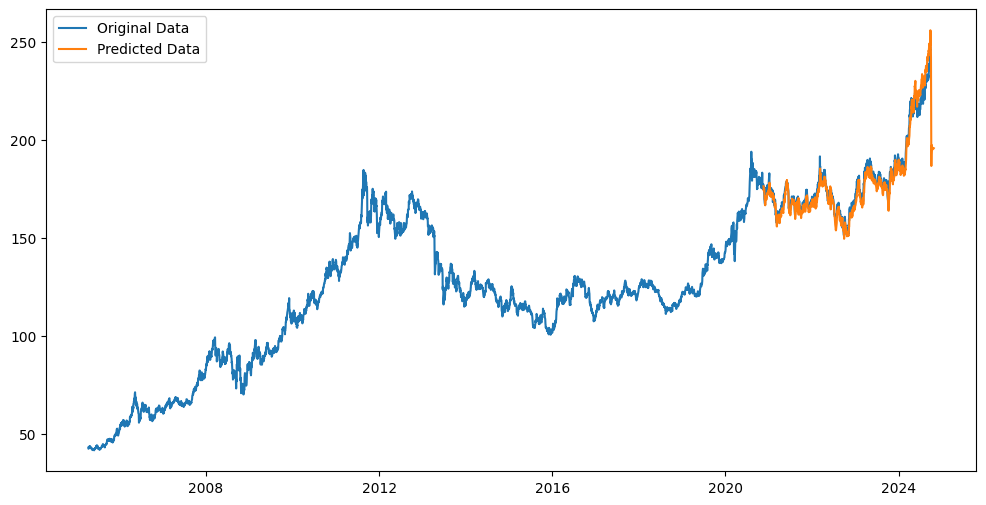

In [29]:
# Plot the data including future predictions
plt.figure(figsize=(12,6))
plt.plot(full_dates, original_data_full, label='Original Data')
plt.plot(full_dates, predicted_data_full, label='Predicted Data')
plt.legend()
plt.show()